# Exploratory Data Analysis, Feature Engineering and Feature Selection for Summarised Sales Data

## Executive Summary

**What is this notebook for?**

- To explore the data properties, data quality and prediction power of categorical and numerical features from the summarised sales data 
- To select relevant features and perform initial feature engineering, getting ready for experimenting with baseline ML models

**What have we learned from this notebook?**

1. Feature Selection
    1. Retain: liquor_type (category_name), origin (category_name), county, item_description, day_of_week, pack_size, bottle_size, month (date), day_of_week (date), city
    2. KIV for further feature engineering:
        - city: enrich with population to see what could explain the vast difference in demand across cities. 
    3. Discard: year, date, pack, bottle_volume_ml, sales_dollar, volume_sold_liters
2. Stationarity: Bottles_sold time series is non-stationary. Hence ARMA is not suitable for demand forecasting. 

**What are the next steps after this notebook?**
1. Build a Machine Learning pipeline to automate data ingestion, data validation and data preprocessing
2. Experiment with time series model: ARIMA, Linear Regression, Random Forest Regression, XGBoost and so on

## Data Sources

summarised_sales.pkl: Summarised from all_sales.pkl

## Revision History

- 04-17-2021: Started the notebook

## Required Python Libraries

In [100]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

# Chi-square test and t-test for EDA
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import pearsonr

# Logistic correlation for EDA
import statsmodels.api as sm
from statsmodels.formula.api import ols # ANOVA test 
from statsmodels.tsa.stattools import kpss # KPSS stationarity test
from statsmodels.tsa.stattools import adfuller # ADF stationarity test
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Data Visualisation for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib so it uses Jupyter's graphical backend when plotting the charts
%matplotlib inline 

# Adjust display options for pandas dataframes
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)
pd.set_option('float_format','{:.2f}'.format)

## File Locations

In [2]:
raw_data = Path.cwd().parent / "data" / "raw" / "all_sales.parquet"

# Summarise transactional data into training dataset for demand forecasting
summarised_data = Path.cwd().parent / "data" / "processed" / "summary_sales.parquet"

# Master file for common dimensions
item_data = Path.cwd().parent / "data" / "interim" / "item_list.pkl"

## Load the data & basic exploration

In [3]:
liquor_df = pd.read_parquet(summarised_data)
liquor_df.tail(10)

,date,item_number,vendor_name,category_name,city,county,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters,item_description
6073609,2021-03-30,991350,Mara Imports,100% Agave Tequila,Coralville,JOHNSON,750,72.00,108.00,6,648.00,6,4.50,Hoyo 19 Extra Anejo
6073610,2021-03-31,28894,BACARDI USA INC,Imported Dry Gins,Washington,WASHINGTON,50,120.00,180.00,1,180.00,1,0.05,Bombay Bramble
6073611,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Ankeny,POLK,750,9.99,14.99,6,44.97,3,2.25,Absolut Watermelon
6073612,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Cedar Falls,BLACK HAWK,750,9.99,14.99,6,44.97,3,2.25,Absolut Watermelon
6073613,2021-03-31,37403,PERNOD RICARD USA,Imported Flavored Vodka,Des Moines,POLK,750,9.99,14.99,6,59.96,4,3.00,Absolut Watermelon
6073614,2021-03-31,38530,SAZERAC COMPANY INC,American Vodkas,Cedar Falls,BLACK HAWK,50,4.30,6.45,12,6.45,1,0.05,Wheatley Vodka Mini
6073615,2021-03-31,57279,SAZERAC COMPANY INC,Cocktails / RTD,Cedar Rapids,LINN,1750,6.50,9.75,6,58.50,6,10.50,Chi-Chi's Pink Lemonade Margarita
6073616,2021-03-31,917527,Brown Forman Corp.,Straight Bourbon Whiskies,Allerton,WAYNE,750,17.15,25.73,6,154.38,6,4.50,Coopers' Craft Reserve Kentucky Straight Bourb...
6073617,2021-03-31,946606,Modern Matriarch,Gold Rum,Council Bluffs,POTTAWATTA,750,14.00,21.00,12,504.00,24,18.00,Modern Matriarch Amber Rum
6073618,2021-03-31,946608,Modern Matriarch,Flavored Rum,Council Bluffs,POTTAWATTA,750,13.75,20.63,12,495.12,24,18.00,Modern Matriarch Salted Caramel Flavored Rum


In [4]:
liquor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6073619 entries, 0 to 6073618
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   item_number          object        
 2   vendor_name          object        
 3   category_name        object        
 4   city                 object        
 5   county               object        
 6   bottle_volume_ml     int64         
 7   state_bottle_cost    float64       
 8   state_bottle_retail  float64       
 9   pack                 int64         
 10  sale_dollars         float64       
 11  bottles_sold         int64         
 12  volume_sold_liters   float64       
 13  item_description     object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 695.1+ MB


In [5]:
liquor_df.describe()

,bottle_volume_ml,state_bottle_cost,state_bottle_retail,pack,sale_dollars,bottles_sold,volume_sold_liters
count,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00,6073619.00
mean,883.16,10.76,16.14,11.93,192.88,14.66,12.16
std,502.05,9.88,14.82,7.50,630.66,49.87,46.77
min,20.00,0.33,0.50,1.00,1.30,1.00,0.02
25%,750.00,6.00,9.00,6.00,37.48,3.00,1.75
50%,750.00,8.66,12.99,12.00,89.16,6.00,6.00
75%,1000.00,13.00,19.50,12.00,180.00,12.00,10.50
max,6000.00,1871.20,2806.80,60.00,185248.80,7920.00,11812.50


In [6]:
# Check for missing values
liquor_df.isnull().sum()

date                   0
item_number            0
vendor_name            0
category_name          0
city                   0
county                 0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
pack                   0
sale_dollars           0
bottles_sold           0
volume_sold_liters     0
item_description       0
dtype: int64

Since majority of the univariate analysis have been covered in notebook 2-DataPrep, the below section will focus more on bivariate analysis and multi-variate analysis to discover underlying patterns about liquor demand in Iowa from 2018. 

As demand for liquor can be strongly dependent on seasonality as well as specific type of liquor, brands, location, pack size and packaging volume, I will focus on exploring the correlations between bottles_sold and other independent variables such as date, vendor, category, city, county, pack, bottle_volume_ml. 

In [7]:
# Add month, year and day of week to analyse liquor demand over time
liquor_df['month'] = pd.DatetimeIndex(liquor_df['date']).month
liquor_df['year'] = pd.DatetimeIndex(liquor_df['date']).year
liquor_df['day_of_week'] = pd.DatetimeIndex(liquor_df['date']).dayofweek

## Exploratory Questions

My primary interest is correlations between bottles_sold and other independent variables such as date, vendor, category, city, county, pack, bottle_volume_ml. As demand for liquor can be strongly dependent on seasonality as well as specific type of liquor, brands, location, pack size and packaging volume, these exploratory questions hold potential knowledge on the market and demand across a wide range of liquor products. 

Based on this initial direction, I formulated the following set of questions for further exploration. 
1. Overall product mix
    - How many types/ categories of liquor products are currently sold in Iowa? 
    - Which types of liquor are the best-seller? 
    - Which brands are the most popular? 
    - Which pack size are available for liquor products? 
    - Which pack size are the most popular? 
    - Which packaging volume are the best-seller? 
2. Seasonality
    - Does seasonality affect liquor consumption in Iowa? (Are there specific months/ period of the year where liquor purchase increased significantly?)
3. Location
    - How different or similar is the consumption of liquor across cities/ counties? 
4. Vendor
5. Pack & packaging volume

Since EDA is an open-ended and iterative process, I expect the above questions to change and increase over time. 

## Recap: General Knowledge

Below are some key takeaways from my background research about the definition of liquor and an overview about liquor market in Iowa

#### Liquor

1. The key difference between wine and liquor is their alcohol content. Wine has a lower alcohol content (typically less than 15%) whereas liquor has a high alcohol content (typically over 30%). 
2. Liquor goes through the process of distillation after fermentation. The process of distillation removes diluting agents like water from the mixture, increasing the alcohol content of the mixture. Hence it is also known as distilled beverage, hard alcohol and spirits.
3. Among the many distilled spirits available in the market, there are just six base liquors: brandy, rum, vodka, gin, tequila and whiskey. These liquors form the foundation of most cocktails used in the bar. 
4. Liquers are sweetened liquor with various flavours, oils and extracts. The alcohol content of liqueurs tends to be lower than liquors because of the additives. Examples include cream liqueurs (like Baileys Irish Cream), orange liqueur (like Grand Marnier), Kahlua.

#### History and recent updates about liquor market in Iowa

According to the [State Library of Iowa](https://www.statelibraryofiowa.org/services/collections/law-library/HistoricalFAQ/Q14), in 1934, Iowa state passed the "Iowa Liquor Control Act" which states that Iowa state assumed direct control over the wholesale and retail distribution of all alcoholic beverages except beer. This is followed by another reorganisation in 1986 whereby the Alcoholic Beverages Division's involvement with the liquor retail business came to an end. However, **the division still controls the wholesaling of liquor as well as the licensing and regulating of the state's alcoholic beverages industry until today.** 

[Des Moines Register](https://www.desmoinesregister.com/story/money/business/2020/12/11/iowa-broke-liquor-sales-records-fiscal-year-2020-black-velvet-whiskey-is-favorite-alcohol-laws/6512397002/) stated that **in the fiscal year 2020, Iowa made a record USD367.3 million in liquor sales — an increase of 8.2% from 2019,** according to the ABD report. Sales generated more than USD133 million in revenue for Iowa, which will go to the state's general fund. 

It's no surprise then that Black Velvet Whisky held onto its longtime No. 1 spot as the best selling liquor in Iowa, according to the annual report from the Iowa Alcoholic Beverages Division. Tito’s Handmade Vodka, Captain Morgan Original Spiced Rum, Hawkeye Vodka and Fireball Cinnamon Whiskey rounded out the top five this year. In local brands, Blue Ox Vodka held onto its top position, followed by Templeton Rye and Cedar Ridge Bourbon.

Across the state, Polk County ranked first in the amount of liquor sold, consuming  1,268,688 fiscal year gallons, a 4% increase from 2019 with USD84.8 million in liquor sales. Linn County ranked second with USD32 million and a 6% increase, Scott County ranked third with USD26.6 million at 5%, and Johnson County came in fourth with USD21 million at 3%.

## Categorical Features - Bivariate & Multivariate Analysis

### category_name

#### How does demand across various types of liquor look like across the years?

In [8]:
# Count number of unique values across all categorical data
cat_feature = ['year','month','day_of_week', 'city', 'county', 'category_name', 'vendor_name', 'item_description']
liquor_df[cat_feature].nunique()

year                   4
month                 12
day_of_week            7
city                 443
county               100
category_name         49
vendor_name          268
item_description    5014
dtype: int64

In [9]:
# How many categories of liquor products have been sold in Iowa since 2018?
liquor_df['category_name'].unique()

array(['Scotch Whiskies', 'American Vodkas',
       'Temporary & Specialty Packages', 'Straight Bourbon Whiskies',
       'Canadian Whiskies', 'Whiskey Liqueur', 'Irish Whiskies',
       'Blended Whiskies', 'Bottled in Bond Bourbon', 'Spiced Rum',
       'Straight Rye Whiskies', 'Single Barrel Bourbon Whiskies',
       'Cream Liqueurs', 'Tennessee Whiskies', 'Iowa Distillery Whiskies',
       'Corn Whiskies', 'American Distilled Spirits Specialty',
       'Imported Dry Gins', 'American Dry Gins', 'Flavored Gin',
       'Imported Flavored Vodka', 'Imported Vodkas', 'American Sloe Gins',
       'American Flavored Vodka', 'Single Malt Scotch',
       'Neutral Grain Spirits', 'Aged Dark Rum',
       'Imported Distilled Spirits Specialty', 'Flavored Rum',
       'White Rum', 'Gold Rum', 'American Cordials & Liqueurs',
       'Imported Brandies', 'Imported Cordials & Liqueurs',
       'American Brandies', 'Cocktails / RTD', '100% Agave Tequila',
       'Imported Schnapps', 'American Schnapps

Trying to visualise all 49 categories would be overwhelming and ineffective for analysis. Therefore, I will attempt to further consolidate the product categories into the 6 base liquors, one "Liqueur" category, one "Specialty" category, and one "Others" category.

Note: 
- Bourbon and Scotch are also classified under Whiskey.
- Schnapps, Triple Sec, Whiskey Liqueur are classified under Liqueur

In [10]:
# Consolidate the category_name into liquor_type
liquor_df['liquor_type'] = liquor_df['category_name'].replace({'Scotch Whiskies': 'Whiskey'
                                                               , 'American Vodkas': 'Vodka'
                                                               , 'Temporary & Specialty Packages': 'Specialty'
                                                               , 'Straight Bourbon Whiskies': 'Whiskey'
                                                               , 'Canadian Whiskies': 'Whiskey'
                                                               , 'Whiskey Liqueur': 'Liqueur'
                                                               , 'Irish Whiskies': 'Whiskey'
                                                               , 'Blended Whiskies': 'Whiskey'
                                                               , 'Bottled in Bond Bourbon': 'Whiskey'
                                                               , 'Spiced Rum': 'Rum'
                                                               , 'Straight Rye Whiskies': 'Whiskey'
                                                               , 'Single Barrel Bourbon Whiskies': 'Whiskey'
                                                               , 'Cream Liqueurs': 'Liqueur'
                                                               , 'Tennessee Whiskies': 'Whiskey'
                                                               , 'Iowa Distillery Whiskies': 'Whiskey'
                                                               , 'Corn Whiskies': 'Whiskey'
                                                               , 'American Distilled Spirits Specialty' : 'Specialty'
                                                               , 'Imported Dry Gins': 'Gin'
                                                               , 'American Dry Gins': 'Gin'
                                                               , 'Flavored Gin': 'Gin'
                                                               , 'Imported Flavored Vodka': 'Vodka'
                                                               , 'Imported Vodkas': 'Vodka'
                                                               , 'American Sloe Gins': 'Gin'
                                                               , 'American Flavored Vodka': 'Vodka'
                                                               , 'Single Malt Scotch': 'Whiskey'
                                                               , 'Neutral Grain Spirits': 'Others'
                                                               , 'Aged Dark Rum' : 'Rum'
                                                               , 'Imported Distilled Spirits Specialty': 'Specialty'
                                                               , 'Flavored Rum': 'Rum'
                                                               , 'White Rum': 'Rum'
                                                               , 'Gold Rum': 'Rum'
                                                               , 'American Cordials & Liqueurs': 'Liqueur'
                                                               , 'Imported Brandies': 'Brandy'
                                                               , 'Imported Cordials & Liqueurs': 'Liqueur'
                                                               , 'American Brandies': 'Brandy'
                                                               , 'Cocktails / RTD': 'Others'
                                                               , '100% Agave Tequila': 'Tequila'
                                                               , 'Imported Schnapps': 'Liqueur'
                                                               , 'American Schnapps': 'Liqueur'
                                                               , 'Coffee Liqueurs': 'Liqueur'
                                                               , 'Neutral Grain Spirits Flavored': 'Others'
                                                               , 'Triple Sec': 'Liqueur'
                                                               , 'Mixto Tequila': 'Tequila'
                                                               , 'Mezcal': 'Others'
                                                               , 'Special Order Items': 'Others'
                                                               , 'Distilled Spirits Specialty': 'Specialty'
                                                               , 'Imported Gins': 'Gin'
                                                               , 'Delisted / Special Order Items': 'Specialty'
                                                               , 'Imported Whiskies': 'Whiskey'})

In [11]:
# Define a function to plot two categorical variables against a numerical label
def multivariate_barplot(df, cat_1, cat_2, num_label):
    # Summarise the data into a pivot table
    pv_table = pd.pivot_table(df, index = [cat_1, cat_2], values = num_label, aggfunc = np.sum)
    # Convert pivot table into a long-form table for visualisation
    data_lf = pv_table.reset_index()
    # Create visualisation 
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    sns.barplot(data = data_lf, x = cat_1, y = num_label, hue = cat_2, palette = "mako")
    return None

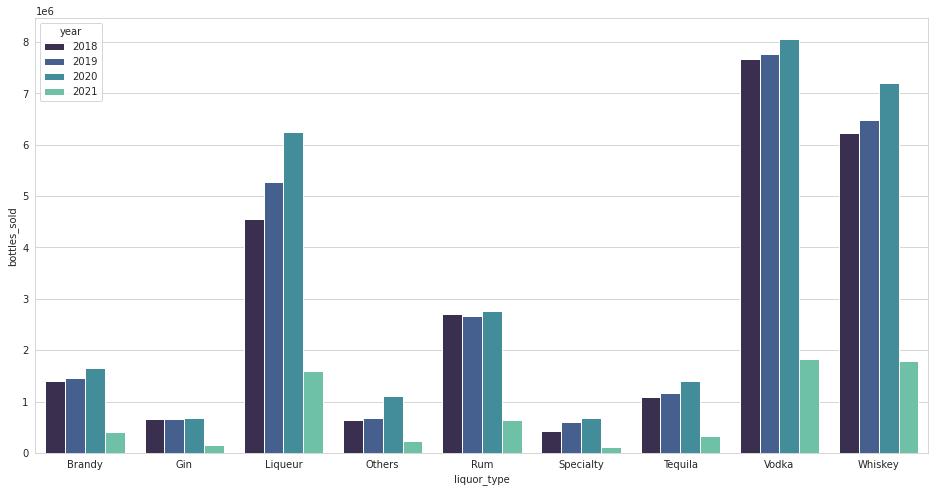

In [12]:
multivariate_barplot(liquor_df, 'liquor_type', 'year', 'bottles_sold')

**In terms of number of bottles sold, vodka is the best-selling liquor type, followed by whiskey, rum, liqueur, gin, brandy, tequilar, specialty and others.** As such, we can clearly see that the demand for liquor differs significantly across liquor types. Therefore, liquor_type would be a relevant feature to predict liquor demand in Iowa. 

Over the years, the wholesale demand for liquor in Iowa has been trending upwards. Despite COVID-19 restrictions and the widespread closure of bars, restaurants and other entertainment venues, the demand for liquor did not drop. Instead, according to news and as evident from the bar chart, **the demand for liquor has increased significantly, indicating that people have switched to consume liquor at homes.** 

Note: At the point of analysis, which is mid-April 2021, we do not have the full 12-month consumption for 2021 yet. Therfore, it is normal for the 2021 data to be much lower than 3 previous years

#### Does the Iowa market prefer imported products or locally produced products?

In [13]:
# Identify product's origin based on category_name
liquor_df['origin'] = liquor_df['category_name'].replace({'Scotch Whiskies': 'Imported'
                                                               , 'American Vodkas': 'Local'
                                                               , 'Temporary & Specialty Packages': 'Unknown'
                                                               , 'Straight Bourbon Whiskies': 'Local'
                                                               , 'Canadian Whiskies': 'Imported'
                                                               , 'Whiskey Liqueur': 'Unknown'
                                                               , 'Irish Whiskies': 'Imported'
                                                               , 'Blended Whiskies': 'Unknown'
                                                               , 'Bottled in Bond Bourbon': 'Local'
                                                               , 'Spiced Rum': 'Unknown'
                                                               , 'Straight Rye Whiskies': 'Unknown'
                                                               , 'Single Barrel Bourbon Whiskies': 'Local'
                                                               , 'Cream Liqueurs': 'Unknown'
                                                               , 'Tennessee Whiskies': 'Local'
                                                               , 'Iowa Distillery Whiskies': 'Local'
                                                               , 'Corn Whiskies': 'Unknown'
                                                               , 'American Distilled Spirits Specialty' : 'Local'
                                                               , 'Imported Dry Gins': 'Imported'
                                                               , 'American Dry Gins': 'Local'
                                                               , 'Flavored Gin': 'Unknown'
                                                               , 'Imported Flavored Vodka': 'Imported'
                                                               , 'Imported Vodkas': 'Imported'
                                                               , 'American Sloe Gins': 'Local'
                                                               , 'American Flavored Vodka': 'Local'
                                                               , 'Single Malt Scotch': 'Imported'
                                                               , 'Neutral Grain Spirits': 'Unknown'
                                                               , 'Aged Dark Rum' : 'Unknown'
                                                               , 'Imported Distilled Spirits Specialty': 'Imported'
                                                               , 'Flavored Rum': 'Unknown'
                                                               , 'White Rum': 'Unknown'
                                                               , 'Gold Rum': 'Unknown'
                                                               , 'American Cordials & Liqueurs': 'Local'
                                                               , 'Imported Brandies': 'Imported'
                                                               , 'Imported Cordials & Liqueurs': 'Imported'
                                                               , 'American Brandies': 'Local'
                                                               , 'Cocktails / RTD': 'Unknown'
                                                               , '100% Agave Tequila': 'Imported'
                                                               , 'Imported Schnapps': 'Imported'
                                                               , 'American Schnapps': 'Local'
                                                               , 'Coffee Liqueurs': 'Unknown'
                                                               , 'Neutral Grain Spirits Flavored': 'Unknown'
                                                               , 'Triple Sec': 'Imported'
                                                               , 'Mixto Tequila': 'Imported'
                                                               , 'Mezcal': 'Imported'
                                                               , 'Special Order Items': 'Unknown'
                                                               , 'Distilled Spirits Specialty': 'Unknown'
                                                               , 'Imported Gins': 'Imported'
                                                               , 'Delisted / Special Order Items': 'Unknown'
                                                               , 'Imported Whiskies': 'Imported'})

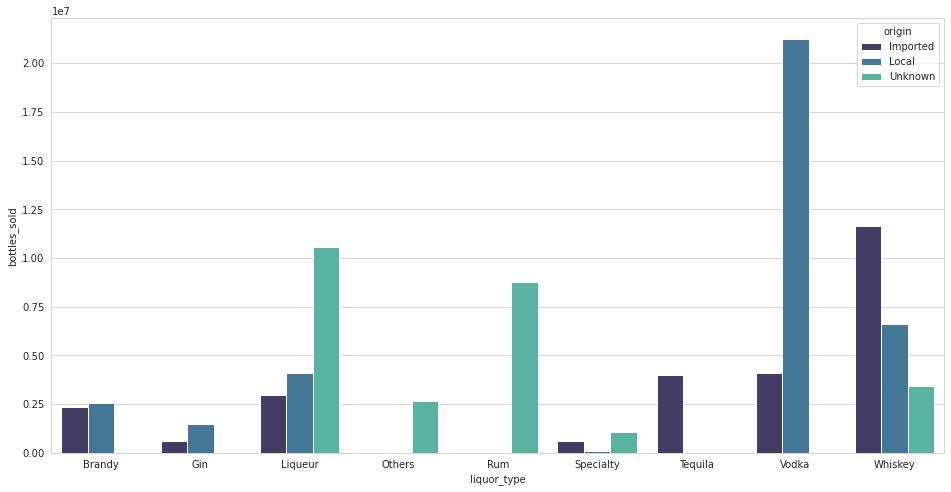

In [14]:
# Plot a chart to visualise the dominance of local vs imported products across liquor types
multivariate_barplot(liquor_df, 'liquor_type', 'origin', 'bottles_sold')

The above chart does not clearly tell whether imported or locally produced liquor is more popular because many has origin classified as "Unknown". As much as possible, I want to minimise the number of bottles sold being classified with Unknown origin since it might mislead my understanding about the liquor market. Therefore, I would attempt to further classify the origin for major brands related to Liqueur, Rum, Whiskey, Others and Specialty based on background research.

For LIQUEUR, below are the applicable classification rules.
1. Imported Products: Baileys, Yukon Jack, Kahlua, Fireball, Ryan's Cream
2. Local Products: Dr (stands for Dr. McGillicuddy's), Tippy Cow, Atomic Fusion, Blue Ox, Rebel Yell, Iowish, Iowa

In [15]:
# Classify imported or local LIQUEUR based on item_description

# Mark imported products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Baileys"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Yukon Jack"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Kahlua"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Fireball"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Ryan's Cream"), 'Imported', liquor_df['origin'])

# Mark local products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Dr"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Tippy Cow"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Atomic Fusion"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Blue Ox"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Rebel Yell"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Iowish"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Iowa"), 'Local', liquor_df['origin'])

For WHISKEY, below are the applicable classification rules.
1. Imported Products: Five Star
2. Local Products: Seagrams 7 Crown, Kessler, Templeton, Beam's 8, Hawkeye Blended

In [16]:
# Classify imported or local WHISKEY based on item_description

# Mark imported products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Five Star"), 'Imported', liquor_df['origin'])

# Mark local products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Seagrams 7 Crown"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Kessler"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Templeton"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Beam's 8"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Hawkeye Blended"), 'Local', liquor_df['origin'])

For RUM, below are the applicable classification rules.
1. Imported Products: Captain Morgan, Bacardi, Malibu
2. Local Products: Admiral Nelson

In [17]:
# Classify imported or local RUM based on item_description

# Mark imported products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Captain Morgan"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Bacardi"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Captain Morgan"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Malibu"), 'Imported', liquor_df['origin'])


# Mark local products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Admiral Nelson"), 'Local', liquor_df['origin'])

For OTHERS liquor, below are the applicable classification rules.
1. Imported Products: Jose Cuervo, 1800, Margaritaville
2. Local Products: Chi-Chi's, Everclear Alcohol, Desert Island Long Island, Ole Smoky, Midnight Moon, Salvador's, Skinnygirl, Ice Box Mudslide, Tooters

In [18]:
# Classify imported or local OTHERS based on item_description

# Mark imported products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Jose Cuervo"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("1800"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Margaritaville"), 'Imported', liquor_df['origin'])

# Mark local products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Chi-Chi's"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Everclear Alcohol"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Desert Island Long Island"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Ole Smoky"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Midnight Moon"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Salvador's"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Skinnygirl"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Ice Box Mudslide"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Tooters"), 'Local', liquor_df['origin'])


For SPECIALTY liquor, below are the applicable classification rules.
1. Imported Products: Crown Royal, Smirnoff Peppermint Twist, Ciroc
2. Local Products: Smirnoff Red, White & Berry, Jack Daniels

In [19]:
# Classify imported or local SPECIALTY based on item_description

# Mark imported products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Crown Royal"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Smirnoff Peppermint Twist"), 'Imported', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Ciroc"), 'Imported', liquor_df['origin'])

# Mark local products
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Smirnoff Red, White & Berry"), 'Local', liquor_df['origin'])
liquor_df['origin'] = np.where(liquor_df['item_description'].str.startswith("Jack Daniels"), 'Local', liquor_df['origin'])

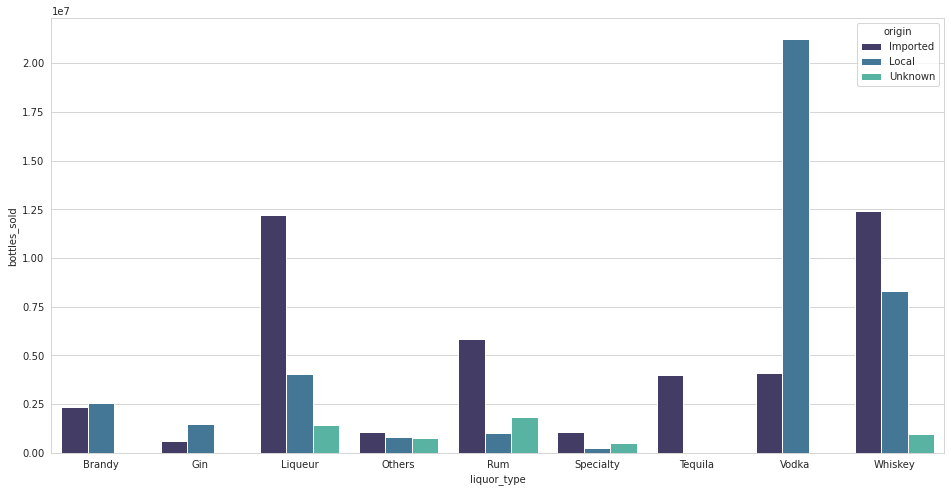

In [20]:
# Plot a chart to visualise the dominance of local vs imported products across liquor types
multivariate_barplot(liquor_df, 'liquor_type', 'origin', 'bottles_sold')

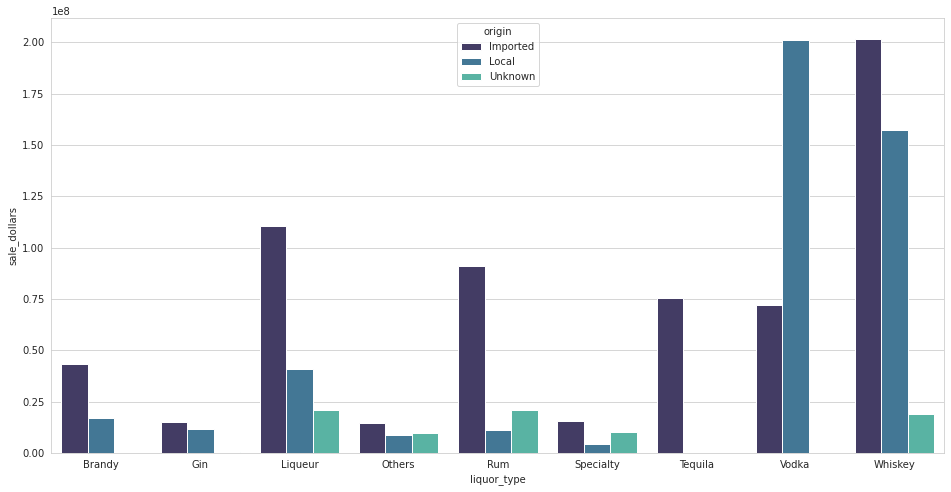

In [21]:
# Plot a chart to visualise the dominance of local vs imported products across liquor types
multivariate_barplot(liquor_df, 'liquor_type', 'origin', 'sale_dollars')

After identifying the origin of major products, I can conclude that **based on the number of bottles sold, imported varieties clearly dominated the market for liqueur, rum, tequila, whiskey and specialty (i.e. special-edition or seasonal products). On the contrary, US brandy, gin and vodka is consumed more than their imported varieties.** 

In terms of sales revenue, the same trend is also observed, except for brandy. **Although the number of imported bottles sold was lower than that of locally produced varieties, the total sales revenue from imported bottles were might higher. This indicates imported brandy is marketed at a much higher price tag than locally produced alternatives.** 

Due to the distinctly different demand between locally produced and imported liquor across liquor types, there could be strong correlation between origin and total number of bottles sold. Therefore I would retain origin as a relevant feature. 

#### Zooming into each liquor type, what categories are the most popular in Iowa? 

In [22]:
# Isolate only records related to each liquor type
brandy = liquor_df[liquor_df['liquor_type'] == "Brandy"]
gin = liquor_df[liquor_df['liquor_type'] == "Gin"]
tequila = liquor_df[liquor_df['liquor_type'] == "Tequila"]
whiskey = liquor_df[liquor_df['liquor_type'] == "Whiskey"]
vodka = liquor_df[liquor_df['liquor_type'] == "Vodka"]
liqueur = liquor_df[liquor_df['liquor_type'] == "Liqueur"]
rum = liquor_df[liquor_df['liquor_type'] == "Rum"]
other = liquor_df[liquor_df['liquor_type'] == "Others"]
specialty = liquor_df[liquor_df['liquor_type'] == "Specialty"]

In [23]:
liquor_type_by_category = pd.pivot_table(liquor_df, index = ['liquor_type', 'category_name'], values = 'bottles_sold', aggfunc = np.sum)
liquor_type_by_category = liquor_type_by_category.reset_index()
liquor_type_by_category

,liquor_type,category_name,bottles_sold
0,Brandy,American Brandies,2565144
1,Brandy,Imported Brandies,2334260
2,Gin,American Dry Gins,1493086
3,Gin,American Sloe Gins,11414
4,Gin,Flavored Gin,34760
5,Gin,Imported Dry Gins,630966
6,Gin,Imported Gins,120
7,Liqueur,American Cordials & Liqueurs,1982592
8,Liqueur,American Schnapps,2113201
9,Liqueur,Coffee Liqueurs,345726


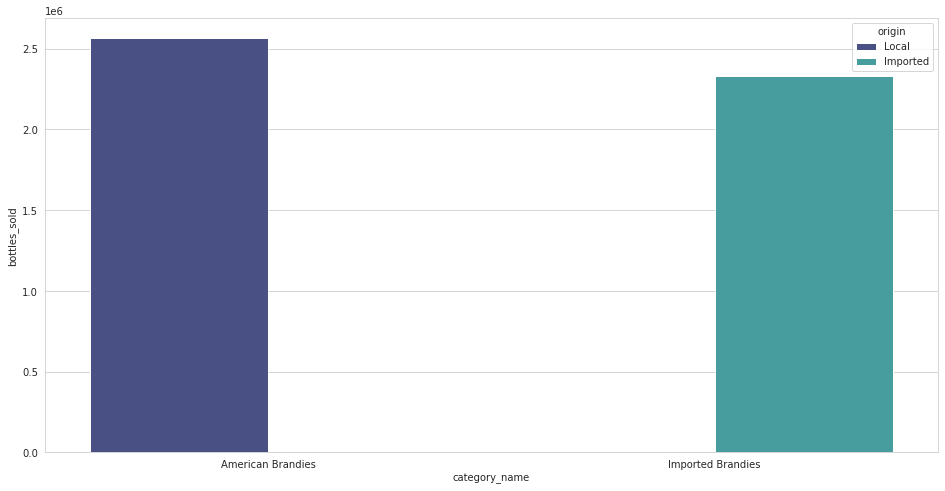

In [24]:
# Plot a chart to visualise the most popular product category for BRANDY
multivariate_barplot(brandy, 'category_name', 'origin', 'bottles_sold')

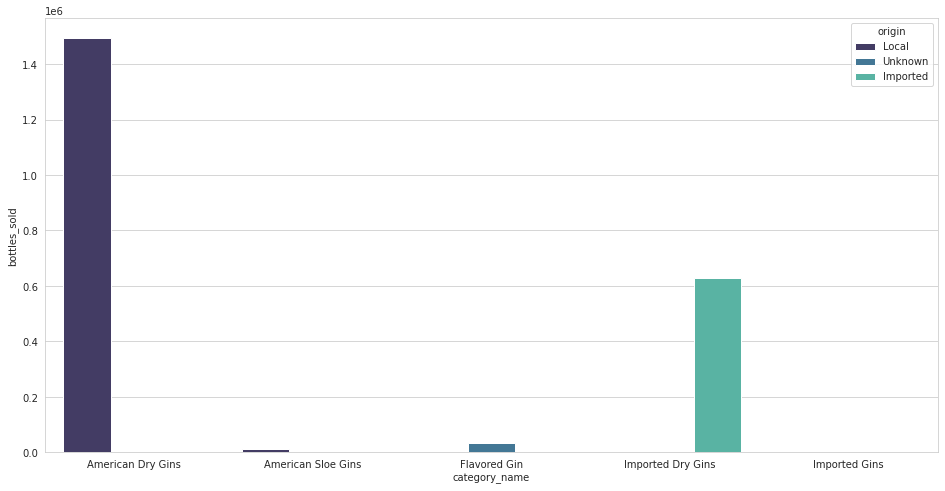

In [25]:
# Plot a chart to visualise the most popular product category for GIN
multivariate_barplot(gin, 'category_name', 'origin', 'bottles_sold')

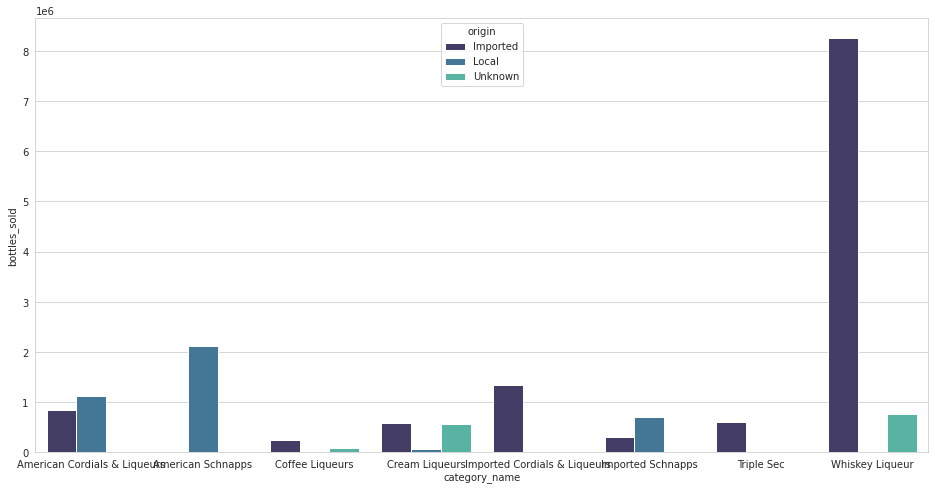

In [26]:
# Plot a chart to visualise the most popular product category for LIQUEUR
multivariate_barplot(liqueur, 'category_name', 'origin', 'bottles_sold')

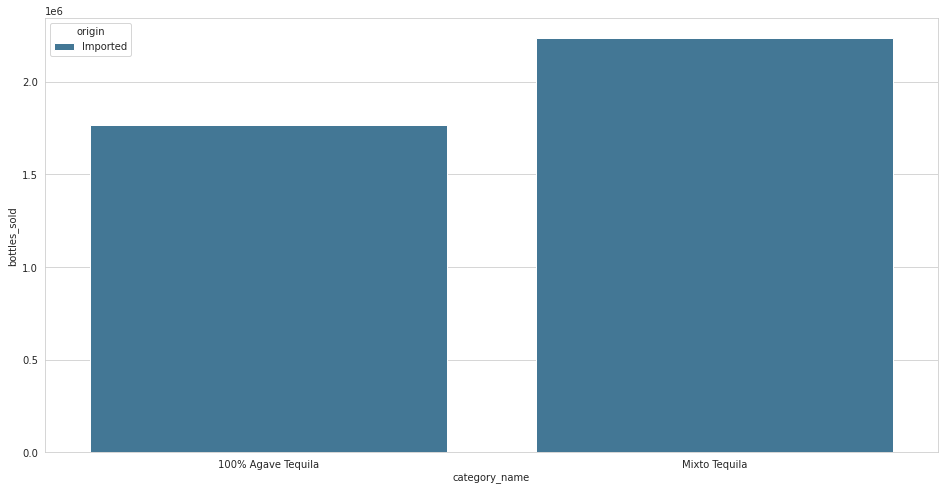

In [27]:
# Plot a chart to visualise the most popular product category for TEQUILA
multivariate_barplot(tequila, 'category_name', 'origin', 'bottles_sold')

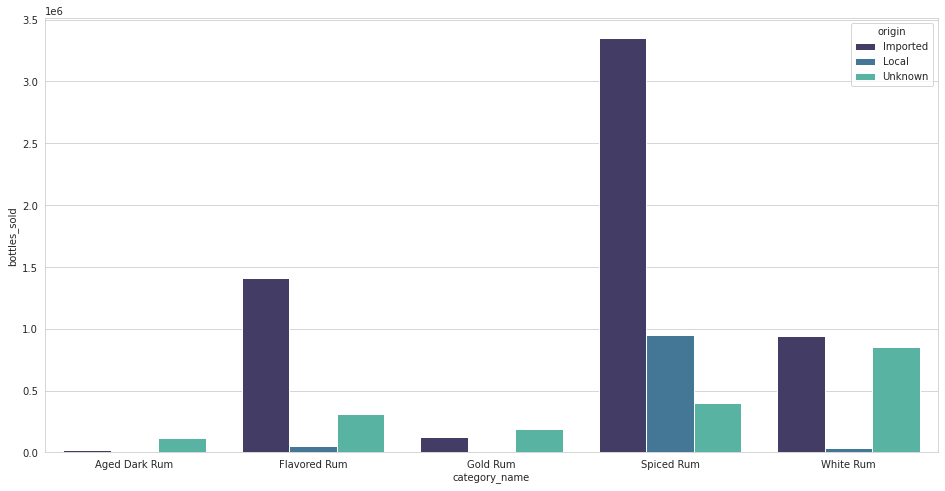

In [28]:
# Plot a chart to visualise the most popular product category for RUM
multivariate_barplot(rum, 'category_name', 'origin', 'bottles_sold')

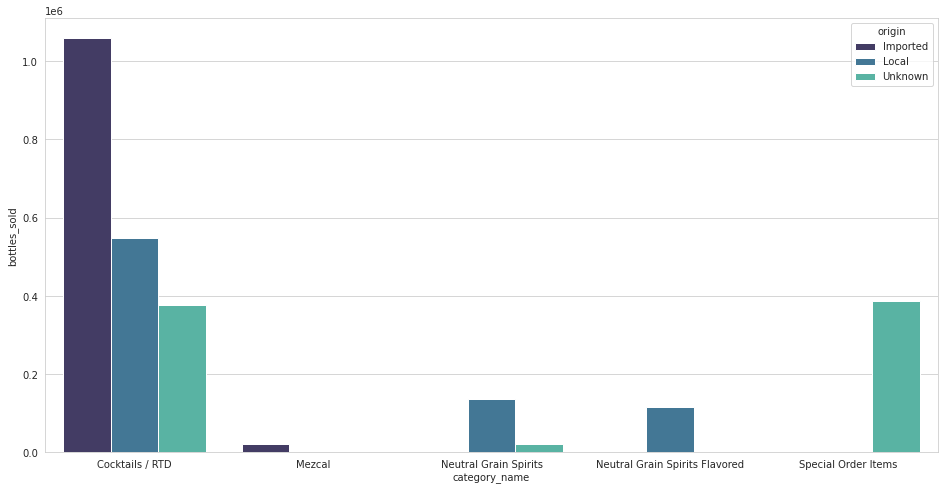

In [29]:
# Plot a chart to visualise the most popular product category for OTHERS
multivariate_barplot(other, 'category_name', 'origin', 'bottles_sold')

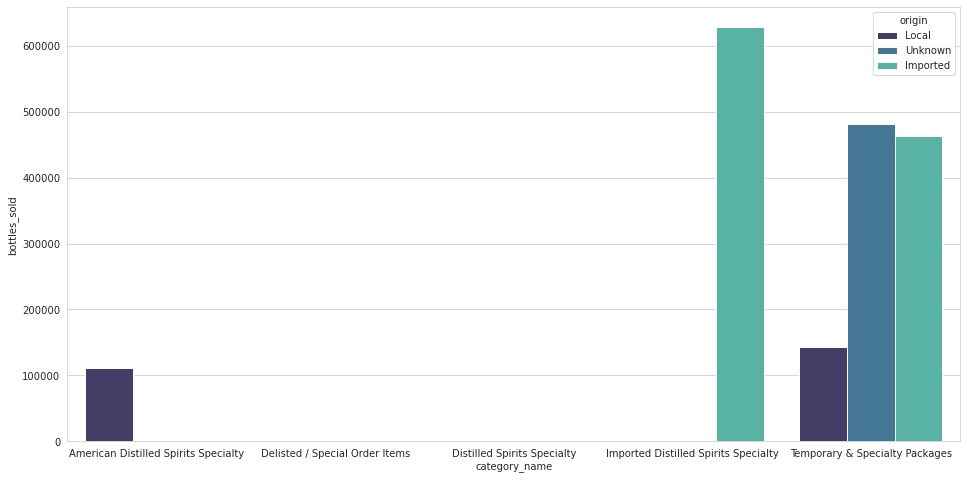

In [30]:
# Plot a chart to visualise the most popular product category for SPECIALTY
multivariate_barplot(specialty, 'category_name', 'origin', 'bottles_sold')

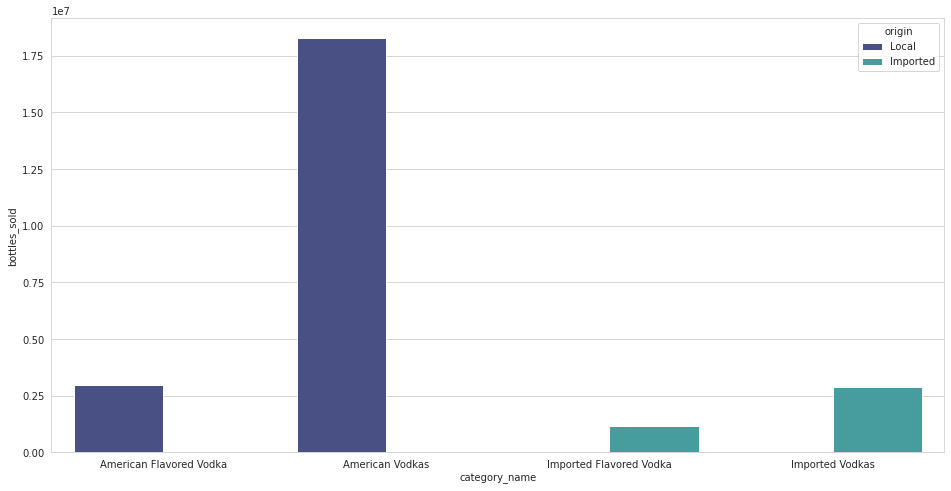

In [31]:
# Plot a chart to visualise the most popular product category for VODKA
multivariate_barplot(vodka, 'category_name', 'origin', 'bottles_sold')

<AxesSubplot:xlabel='bottles_sold', ylabel='category_name'>

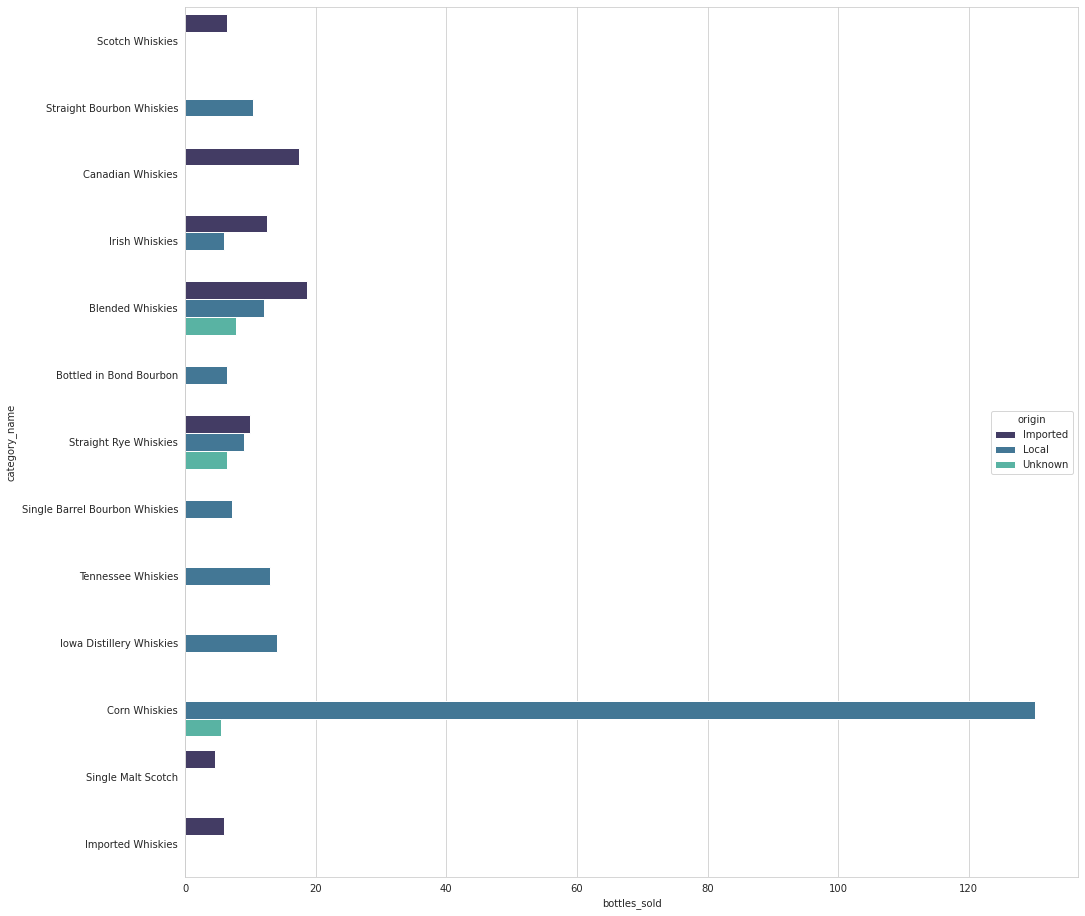

In [32]:
# Plot a chart to visualise the most popular product category for WHISKEY
plt.figure(figsize = (16, 16))
sns.set_style("whitegrid")
sns.barplot(data = whiskey, x = 'bottles_sold', y = 'category_name', hue = 'origin', palette = "mako", ci = None)

Here are some key observations about the most popular varieties across each liquor type: 
1. Whiskey: Corn Whiskies(an American liquor made from a mash of at least 80 percent corn and distilled to a maximum strength of 160 proof (80% alcohol by volume)
2. Vodka: American Vodkas
3. Liquer: Whiskey Liqueur
4. Rum: Spiced Rum
5. Tequila: Mixto Tequila
6. Brandy: American Brandies
7. Gin: American Dry Gin
8. Specialty: Temporary & Specialty Packages
9. Others: Cocktails/ RTD (i.e. ready-to-drink packaged alcoholic beverages)

#### How does liquor_type correlate to bottles_sold?

To assess the correlation between a categorical feature and a numerical label, I can use either t-test (if the categorical feature only has 2 groups) or ANOVA (if categorical feature has more than 2 groups). In this case, I will be using ANOVA test since pack_size has 5 different groups. 

ANOVA tests if there is a statistically significant difference in the mean somewhere in the model (testing if there was an overall effect), but it does not tell us where the difference is (if there is one). Since I am only interested in the correlation between 1 independent variable, I would perform one-way ANOVA test and here is my null and alternate hypothesis. 

- Null Hypothesis – There is no statistically significant difference in bottles_sold among the different pack_size values
- Alternate Hypothesis – There is a statistically significant difference in bottles_sold among the different pack_size values

The result of the ANOVA formula is called the F statistics. Choosing a level of significance of 0.05, if the p-value associated with the F is smaller than 0.05, then the null hypothesis is rejected. 

In [68]:
# Define a function to examine correlation over time between a categorical feature and a numerical label with boxplot and ANOVA
def corr_boxplot_anova(df, cat_var, num_label, date_col):
    # Summarise numerical label over time
    num_label_summary = pd.pivot_table(df, index = [date_col, cat_var], values = num_label, aggfunc = np.sum).reset_index()
    # Draw a boxplot
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    g = sns.boxplot(data = num_label_summary, x = cat_var, y = num_label, hue = cat_var, palette = 'mako')
    # Conduct ANOVA model with ordinary least squares (ols) method in statsmodel
    ols_parameter = num_label + '' + '~' + cat_var
    model = ols(ols_parameter, data = num_label_summary).fit()
    aov_table = sm.stats.anova_lm(model, typ = 2)
    return aov_table

,sum_sq,df,F,PR(>F)
liquor_type,798126672282.93,8.00,5223.45,0.00
Residual,144698526672.37,7576.00,NaN,NaN


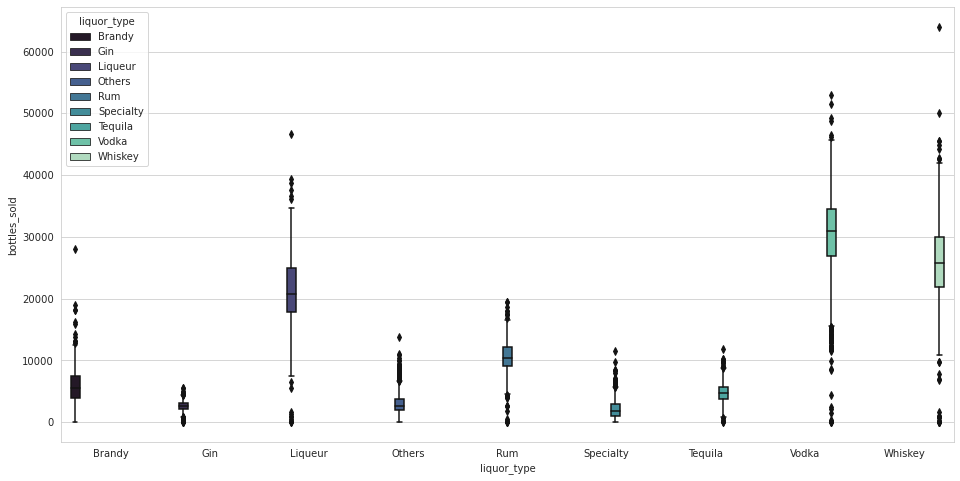

In [123]:
# Assess predictive power of liquor_type
corr_boxplot_anova(liquor_df, 'liquor_type', 'bottles_sold', 'date')

#### How does origin correlate to bottles_sold?

,sum_sq,df,F,PR(>F)
origin,1042594425406.94,2.00,4639.83,0.00
Residual,284589126659.21,2533.00,NaN,NaN


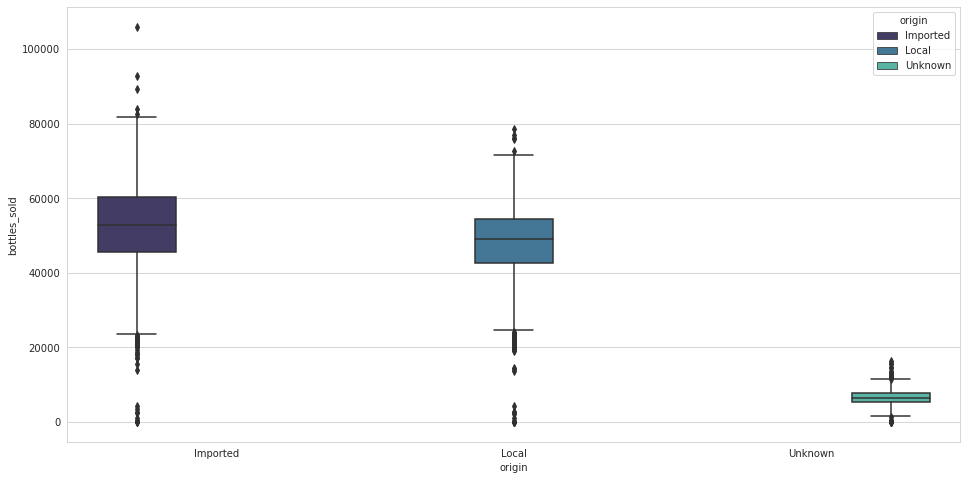

In [127]:
# Assess predictive power of origin
corr_boxplot_anova(liquor_df, 'origin', 'bottles_sold', 'date')

Since category_name has high cardinality while origin and liquor_type have some predictive power over bottles_sold, I would discard category_name and retain origin as well as liquor_type for my demand forecast model. 

### date

In [33]:
# Summary data by year
data_2018 = liquor_df[liquor_df['year'] == 2018]
data_2019 = liquor_df[liquor_df['year'] == 2019]
data_2020 = liquor_df[liquor_df['year'] == 2020]
data_2021 = liquor_df[liquor_df['year'] == 2021]

#### How does demand fluctuate accross years and months? 

In [34]:
# Define a function to plot small multiple time series between one categorical variable against a numerical label across months and years
def multivariate_relplot(df, cat_var, num_label, month_col, year_col):
    # Summarise the data into a pivot table
    pv_table = pd.pivot_table(df, index = [year_col, month_col, cat_var], values = num_label, aggfunc = np.sum)
    # Convert pivot table into a long-form table for visualisation
    data_lf = pv_table.reset_index()
    # Plot each year's time series in its own facet 
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    g = sns.relplot(data = data_lf, x = month_col, y = num_label, col = year_col, hue = cat_var, kind = "line", palette = "dark", col_wrap = 2)
    return None

<Figure size 1152x576 with 0 Axes>

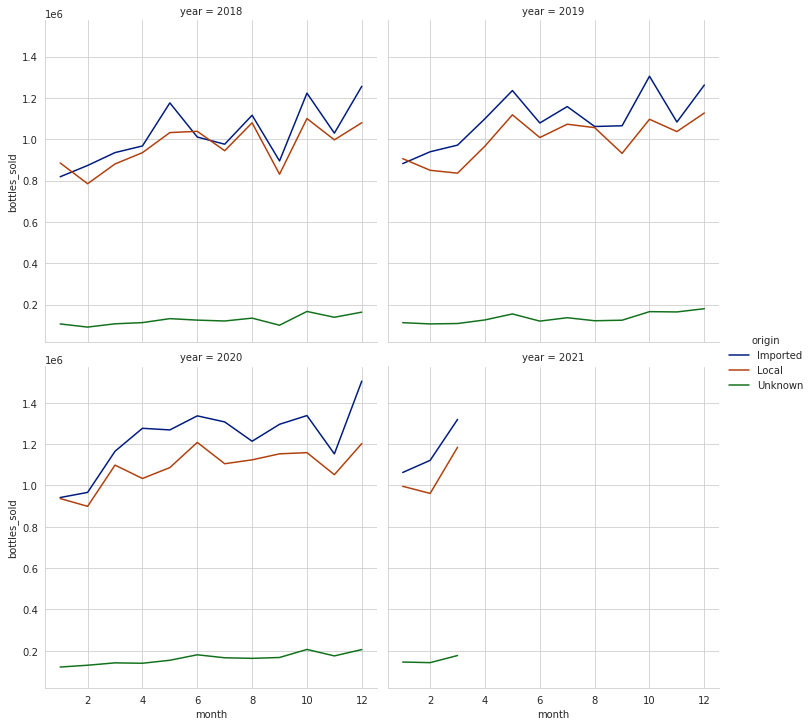

In [35]:
# Plot the number of bottles sold by origin across months and years
multivariate_relplot(liquor_df, 'origin', 'bottles_sold', 'month', 'year')

Based on the above plot, the demand for liquor shows regular fluctuations across months. For example, the higher wholesale sales are observed in May, August, October and December. Wholesale demand usually dipped in February, July, September and November. This could potentially reflect the fact that retailers often stock up before major holidays. 

However, since different liquor types might imply different demand throughout the year, I would look at each liquor type to verify further. 

#### Are fluctuations in demand similar across all liquor types? 

<Figure size 1152x576 with 0 Axes>

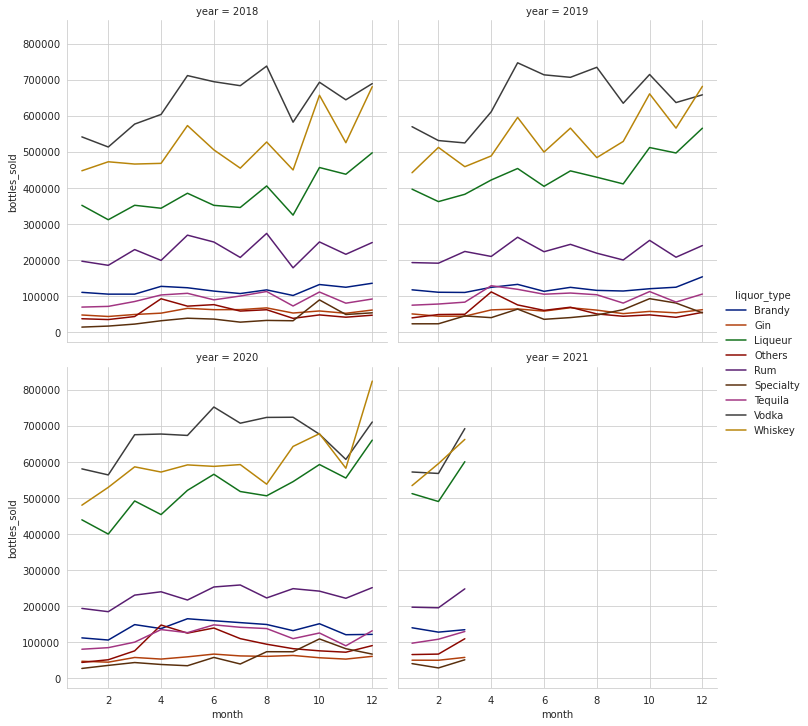

In [36]:
# Plot the number of bottles sold by liquor_type across months and years
multivariate_relplot(liquor_df, 'liquor_type', 'bottles_sold', 'month', 'year')

The above chart showed that the monthly trend in 2018 and 2019 was very similar to each other. However, 2020 witnessed chaotic changes to the wholesale monthly pattern. Therefore, **historical trend and seasonality observed in 2018 and 2019 might not be so relevant to predicting the monthly demand in 2021.** Since future demand is unlikely to mimic patterns of past demand, simplistic time series methods such as moving average or exponential smoothing will not be suitable. Other variables which indicate demand signals have to be considered. 

Nevertheless, certain monthly trends seem to persist during 2020. **Demand consistently rose sharply in the months of March and December across the years. Therefore, I will proceed with statistical hypothesis testing to confirm whether month should be retained as a relevant feature.** 

In 2020, the demand for vodka, whiskey and liqueur increased significantly while that of other liquor types remained stable as compared to 2018 and 2019. This indicates **vodka, whiskey and liqueur have become more popular during the pandemic.**  


#### Does wholesale demand for liquor fluctuate according to days of week? 

<Figure size 1152x576 with 0 Axes>

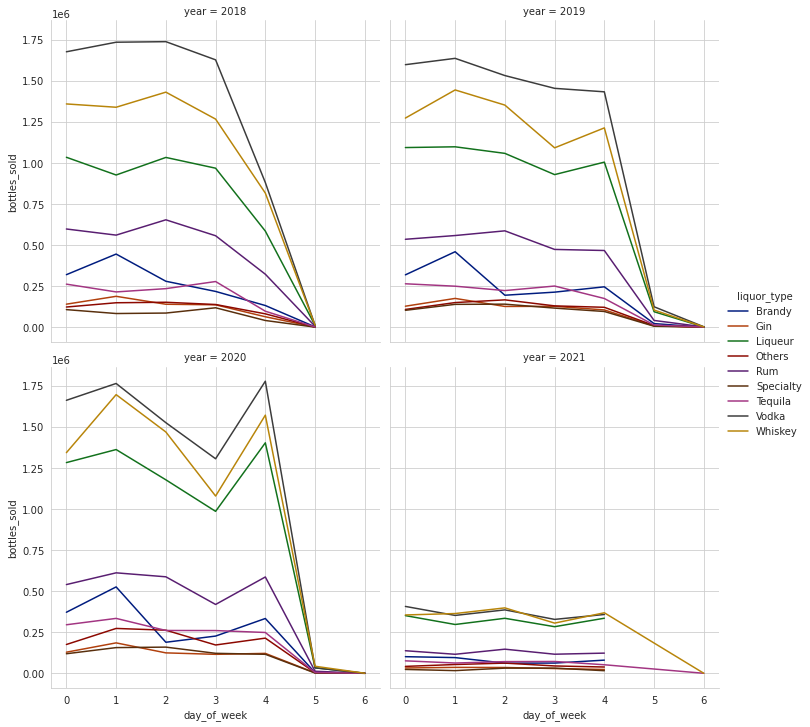

In [37]:
# Plot the number of bottles sold by liquor_type across day of week and years
multivariate_relplot(liquor_df, 'liquor_type', 'bottles_sold', 'day_of_week', 'year')

A sharp rise in bottles sold by the Alcoholic Beverage Division every Tuesday and Friday showed that majority of retail stores often stock up their liquor products twice a week. During the weekends, the division's wholesale operations open on Saturday but close on Sunday. 

#### How does month correlate to bottles_sold?

,sum_sq,df,F,PR(>F)
month,24621756876.86,1.00,34.61,0.00
Residual,601065636608.85,845.00,NaN,NaN


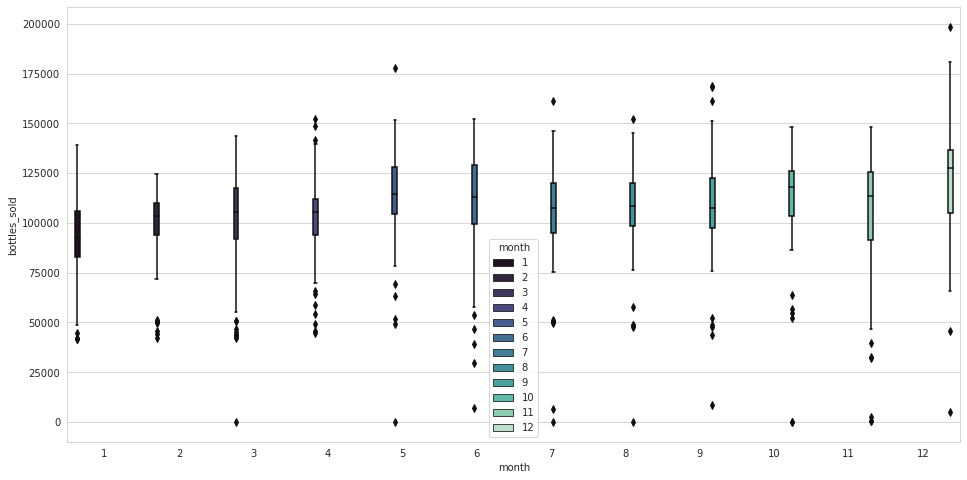

In [121]:
corr_boxplot_anova(liquor_df, 'month', 'bottles_sold', 'date')

Since p-value < 0.05, there is statistically significant different in bottles_sold across months. Therefore, I will retain month as a relevant feature for my demand forecasting model. Since month is already shown in numerical order, encoding might not be required.  

#### How does day_of_week correlate to bottles_sold?

,sum_sq,df,F,PR(>F)
day_of_week,118556363874.02,1.00,197.54,0.00
Residual,507131029611.70,845.00,NaN,NaN


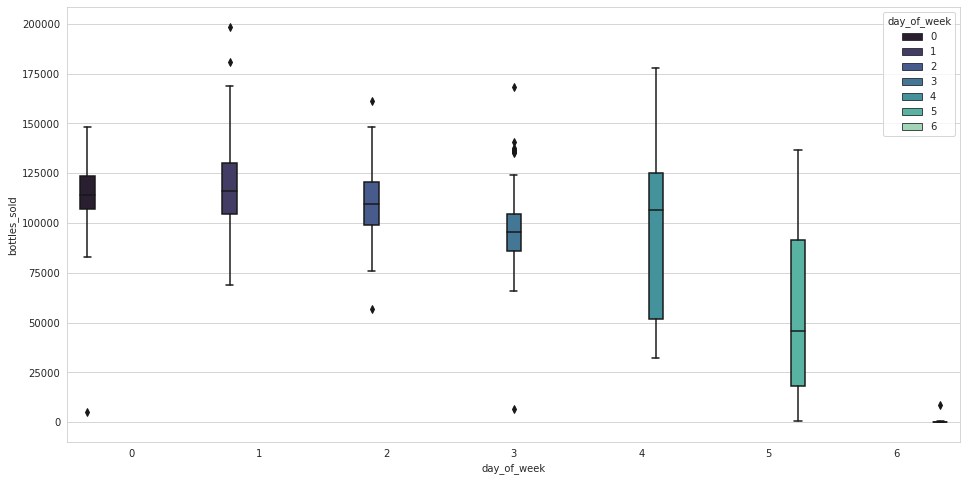

In [122]:
corr_boxplot_anova(liquor_df, 'day_of_week', 'bottles_sold', 'date')

Since p-value < 0.05, there is statistically significant different in bottles_sold throughout the week. Therefore, I will retain day_of_week as a relevant feature for my demand forecasting model. Since day_of_week is already shown in numerical order, encoding might not be required.  

### county

#### Which are the top 5 counties purchased the most bottles in 2020? 

In [38]:
# Summarise county's liquor wholesale demand in 2020
sales_by_county = pd.pivot_table(data_2020, index = ['county'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False).reset_index()

# Calculate percentage of total sales
sales_by_county['total_bottles'] = sales_by_county['bottles_sold'].sum()
sales_by_county['percentage'] = sales_by_county['bottles_sold'] / sales_by_county['total_bottles'] * 100
sales_by_county.head(5)

,county,bottles_sold,total_bottles,percentage
0,POLK,6528449,29768131,21.93
1,LINN,2719150,29768131,9.13
2,SCOTT,2340930,29768131,7.86
3,BLACK HAWK,1768272,29768131,5.94
4,JOHNSON,1497332,29768131,5.03


#### Which are the top 5 county that purchased the most bottles for each liquor type in 2020? 

In [39]:
# Summarise county's liquor wholesale demand in 2020
liquor_type_by_county = pd.pivot_table(data_2020, index = ['liquor_type', 'county'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False).reset_index()
liquor_type_by_county

,liquor_type,county,bottles_sold
0,Vodka,POLK,1887304
1,Liqueur,POLK,1413724
2,Whiskey,POLK,1409927
3,Vodka,LINN,760961
4,Vodka,SCOTT,645404
...,...,...,...
886,Specialty,TAYLOR,97
887,Specialty,FREMONT,60
888,Brandy,FREMONT,24
889,Others,FREMONT,24


In [40]:
# Find the top 5 counties that spent the most across each liquor type
liquor_type_by_county.groupby('liquor_type').head(5).sort_values(['liquor_type', 'bottles_sold'], ascending = False)

,liquor_type,county,bottles_sold
2,Whiskey,POLK,1409927
6,Whiskey,LINN,563971
9,Whiskey,SCOTT,463891
14,Whiskey,JOHNSON,371012
16,Whiskey,BLACK HAWK,360626
0,Vodka,POLK,1887304
3,Vodka,LINN,760961
4,Vodka,SCOTT,645404
10,Vodka,JOHNSON,461163
11,Vodka,BLACK HAWK,420362


#### Which are the 5 counties that spent the least on liquor in 2020? 

In [41]:
sales_by_county.tail(5)

,county,bottles_sold,total_bottles,percentage
94,ADAMS,15702,29768131,0.05
95,TAYLOR,13861,29768131,0.05
96,DAVIS,12130,29768131,0.04
97,RINGGOLD,11760,29768131,0.04
98,FREMONT,7977,29768131,0.03


Contributing to 22.47% of the total wholesale liquor demand in 2020, Polk county topped the chart for spending the most on liquor across all liquor types. Linn, Scott, Johnson and Black Hawk also consistently appeared as the top spender on liquor across all liquor types in 2020.

Overall, the top 5 spenders accounted for 49.65% of liquor wholesale in Iowa in 2020 while the remaining 90+ counties contributed to the remain 50%. Therefore, it is evident that demand for liquor differs tremendously across counties. Hence county will be retained as a relevant feature to predict liquor demand.

#### city

#### Which are the top 5 cities spent the most on liquor in 2020? 

In [42]:
# Summarise city's liquor wholesale demand in 2020
sales_by_city = pd.pivot_table(data_2020, index = ['city'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False).reset_index()

# Calculate percentage of total sales
sales_by_city['total_bottles'] = sales_by_city['bottles_sold'].sum()
sales_by_city['percentage'] = sales_by_city['bottles_sold'] / sales_by_city['total_bottles'] * 100
sales_by_city.head(5)

,city,bottles_sold,total_bottles,percentage
0,Des Moines,3308678,29768131,11.11
1,Cedar Rapids,2076561,29768131,6.98
2,Davenport,1782985,29768131,5.99
3,Waterloo,1179735,29768131,3.96
4,Council Bluffs,1106753,29768131,3.72


It is not a surprised that the capital and the most populous city in Iowa, Des Moines, came first when it comes to alcohol demand. The city alone accounted for 10.5% of the entire wholesale liquor demand of the state. The top 5 cities contributed to 31% of the state's liquor demand in terms of number of bottles sold. 

#### Which are the top 5 cities that spent the most on liquor for each liquor type in 2020? 

In [43]:
# Summarise county's liquor wholesale demand in 2020
liquor_type_by_city = pd.pivot_table(data_2020, index = ['liquor_type', 'city'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False).reset_index()
liquor_type_by_city

,liquor_type,city,bottles_sold
0,Vodka,Des Moines,947819
1,Liqueur,Des Moines,773813
2,Whiskey,Des Moines,616193
3,Vodka,Cedar Rapids,581682
4,Vodka,Davenport,487831
...,...,...,...
3766,Others,Arlington,1
3767,Brandy,Fremont,1
3768,Tequila,Arlington,1
3769,Others,Colesburg,1


In [44]:
# Find the top 5 counties that spent the most across each liquor type
liquor_type_by_city.groupby('liquor_type').head(5).sort_values(['liquor_type', 'bottles_sold'], ascending = False)

,liquor_type,city,bottles_sold
2,Whiskey,Des Moines,616193
6,Whiskey,Cedar Rapids,425699
9,Whiskey,Davenport,336774
13,Whiskey,West Des Moines,266760
19,Whiskey,Sioux City,238523
0,Vodka,Des Moines,947819
3,Vodka,Cedar Rapids,581682
4,Vodka,Davenport,487831
10,Vodka,West Des Moines,336521
12,Vodka,Council Bluffs,270387


#### Which are the 5 cities that spent the least on liquor in 2020? 

In [45]:
sales_by_city[sales_by_city['percentage'] < 0.05]

,city,bottles_sold,total_bottles,percentage
164,Madrid,14710,29768131,0.05
165,Durant,14687,29768131,0.05
166,Audubon,14294,29768131,0.05
167,Lake Mills,14091,29768131,0.05
168,Pacific Junction,13614,29768131,0.05
...,...,...,...,...
425,Murray,863,29768131,0.00
426,Rudd,823,29768131,0.00
427,Allerton,664,29768131,0.00
428,Delhi,637,29768131,0.00


Looking at the specific types of liquor, the top 5 cities show a slightly different list from the overall top 5 spenders. This means different cities have varying taste and preference for certain liquor. Therefore, **the demand for liquor does not only depend on the population but also the specific taste and preference of people within those regions.** A potential influencing factor to taste and preference could be culture or demographics. 

Additionally, a total of 266 out of 443 cities had very little demand for liquor. Each city in this group accounted for zero to 0.05 percent of total liquor demand. A possible theory is that the population in these cities are much smaller than all remaining cities. However, to check this out, I will have to enrich the existing dataset with the city population data. 

Although different cities indicate varying demand for liquor, city feature has very high cardinality, thus posing potential performance problem for the ML model. Therefore, I will have to consider some feature engineering techniques to retain the information while minimising the cardinality. 

#### vendor_name

#### Which are the 10 best-selling vendors in 2020? 

In [46]:
# Summarise county's liquor wholesale demand in 2020
sales_by_vendor = pd.pivot_table(data_2020, index = ['vendor_name'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False)
sales_by_vendor = sales_by_vendor.reset_index()

# Calculate percentage of total sales
sales_by_vendor['total_bottles'] = sales_by_vendor['bottles_sold'].sum()
sales_by_vendor['percentage'] = sales_by_vendor['bottles_sold'] / sales_by_vendor['total_bottles'] * 100
sales_by_vendor.head(10)

,vendor_name,bottles_sold,total_bottles,percentage
0,SAZERAC COMPANY INC,6532428,29768131,21.94
1,DIAGEO AMERICAS,4079302,29768131,13.70
2,Heaven Hill Brands,2459867,29768131,8.26
3,LUXCO INC,2052595,29768131,6.90
4,Jim Beam Brands,2003207,29768131,6.73
5,PERNOD RICARD USA,1439170,29768131,4.83
6,FIFTH GENERATION INC,1144407,29768131,3.84
7,PROXIMO,1046701,29768131,3.52
8,McCormick Distilling Co.,1040277,29768131,3.49
9,BACARDI USA INC,940708,29768131,3.16


#### Which are the top 5 vendors for each liquor type in 2020? 

In [47]:
# Summarise county's liquor wholesale demand in 2020
liquor_type_by_vendor = pd.pivot_table(data_2020, index = ['liquor_type', 'vendor_name'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False)
liquor_type_by_vendor = liquor_type_by_vendor.reset_index()
liquor_type_by_vendor

,liquor_type,vendor_name,bottles_sold
0,Liqueur,SAZERAC COMPANY INC,4287136
1,Whiskey,Heaven Hill Brands,1745332
2,Whiskey,DIAGEO AMERICAS,1460852
3,Whiskey,Jim Beam Brands,1239125
4,Vodka,FIFTH GENERATION INC,1144407
...,...,...,...
571,Whiskey,DUGGANS DISTILLERS,6
572,Gin,Copper & Kings American Brandy Company,6
573,Brandy,Altamar Brands LLC,6
574,Specialty,TY KU LLC,4


In [48]:
# Find the top 5 most popular vendors across each liquor type
liquor_type_by_vendor.groupby('liquor_type').head(5).sort_values(['liquor_type', 'bottles_sold'], ascending = False)

,liquor_type,vendor_name,bottles_sold
1,Whiskey,Heaven Hill Brands,1745332
2,Whiskey,DIAGEO AMERICAS,1460852
3,Whiskey,Jim Beam Brands,1239125
10,Whiskey,Brown Forman Corp.,780145
14,Whiskey,SAZERAC COMPANY INC,483201
4,Vodka,FIFTH GENERATION INC,1144407
6,Vodka,SAZERAC COMPANY INC,997732
7,Vodka,McCormick Distilling Co.,980973
8,Vodka,LUXCO INC,904466
9,Vodka,DIAGEO AMERICAS,901180


The liquor market in Iowa is dominated by giant companies, with the top 10 best-selling vendors accounting for approximately 76.37% of liquor sales in 2020. This means for every 100 liquor bottles sold to liquor retailers in Iowa, 76 bottles come from a small groups of well-established multinational companies that have global operations and possessed a strong product portfolio.

#### item_description

#### Which are the 10 best-selling items in 2020? 

In [49]:
# Summarise county's liquor wholesale demand in 2020
sales_by_item = pd.pivot_table(data_2020, index = ['item_description'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False)
sales_by_item = sales_by_item.reset_index()

# Calculate percentage of total bottles sold
sales_by_item['total_bottles'] = sales_by_item['bottles_sold'].sum()
sales_by_item['percentage'] = sales_by_item['bottles_sold'] / sales_by_item['total_bottles'] * 100
sales_by_item.head(10)

,item_description,bottles_sold,total_bottles,percentage
0,Fireball Cinnamon Whiskey,2675985,29768131,8.99
1,Black Velvet,1275423,29768131,4.28
2,Titos Handmade Vodka,1126422,29768131,3.78
3,Hawkeye Vodka,700685,29768131,2.35
4,Captain Morgan Original Spiced,634900,29768131,2.13
5,McCormick 80prf Vodka PET,545648,29768131,1.83
6,Hennessy VS,434024,29768131,1.46
7,Crown Royal Regal Apple,407538,29768131,1.37
8,Five O'clock Vodka,383743,29768131,1.29
9,McCormick 80prf Vodka,382791,29768131,1.29


#### Which are the top 5 items for each liquor type in 2020? 

In [50]:
# Summarise liquor wholesale demand by item in 2020
liquor_type_by_item = pd.pivot_table(data_2020, index = ['liquor_type', 'item_description'], values = ['bottles_sold']
                                   , aggfunc = np.sum).sort_values('bottles_sold', ascending = False).reset_index()
liquor_type_by_item

,liquor_type,item_description,bottles_sold
0,Liqueur,Fireball Cinnamon Whiskey,2675985
1,Whiskey,Black Velvet,1275423
2,Vodka,Titos Handmade Vodka,1126422
3,Vodka,Hawkeye Vodka,700685
4,Rum,Captain Morgan Original Spiced,634900
...,...,...,...
3528,Whiskey,HA Glenfiddich Project XX,1
3529,Specialty,Avion Extra Anejo w/Waterford Glasses,1
3530,Specialty,Aviation American Gin w/Martini Glasses,1
3531,Others,HA Hancock Reserve Bourbon,1


In [51]:
# Find the top 5 most popular items across each liquor type
liquor_type_by_item.groupby('liquor_type').head(5).sort_values(['liquor_type', 'bottles_sold'], ascending = False)

,liquor_type,item_description,bottles_sold
1,Whiskey,Black Velvet,1275423
7,Whiskey,Crown Royal Regal Apple,407538
10,Whiskey,Jack Daniels Old #7 Black Label,364722
12,Whiskey,Jim Beam,298044
20,Whiskey,Jameson,235190
2,Vodka,Titos Handmade Vodka,1126422
3,Vodka,Hawkeye Vodka,700685
5,Vodka,McCormick 80prf Vodka PET,545648
8,Vodka,Five O'clock Vodka,383743
9,Vodka,McCormick 80prf Vodka,382791


## Numerical Features - Bivariate & Multivariate Analysis

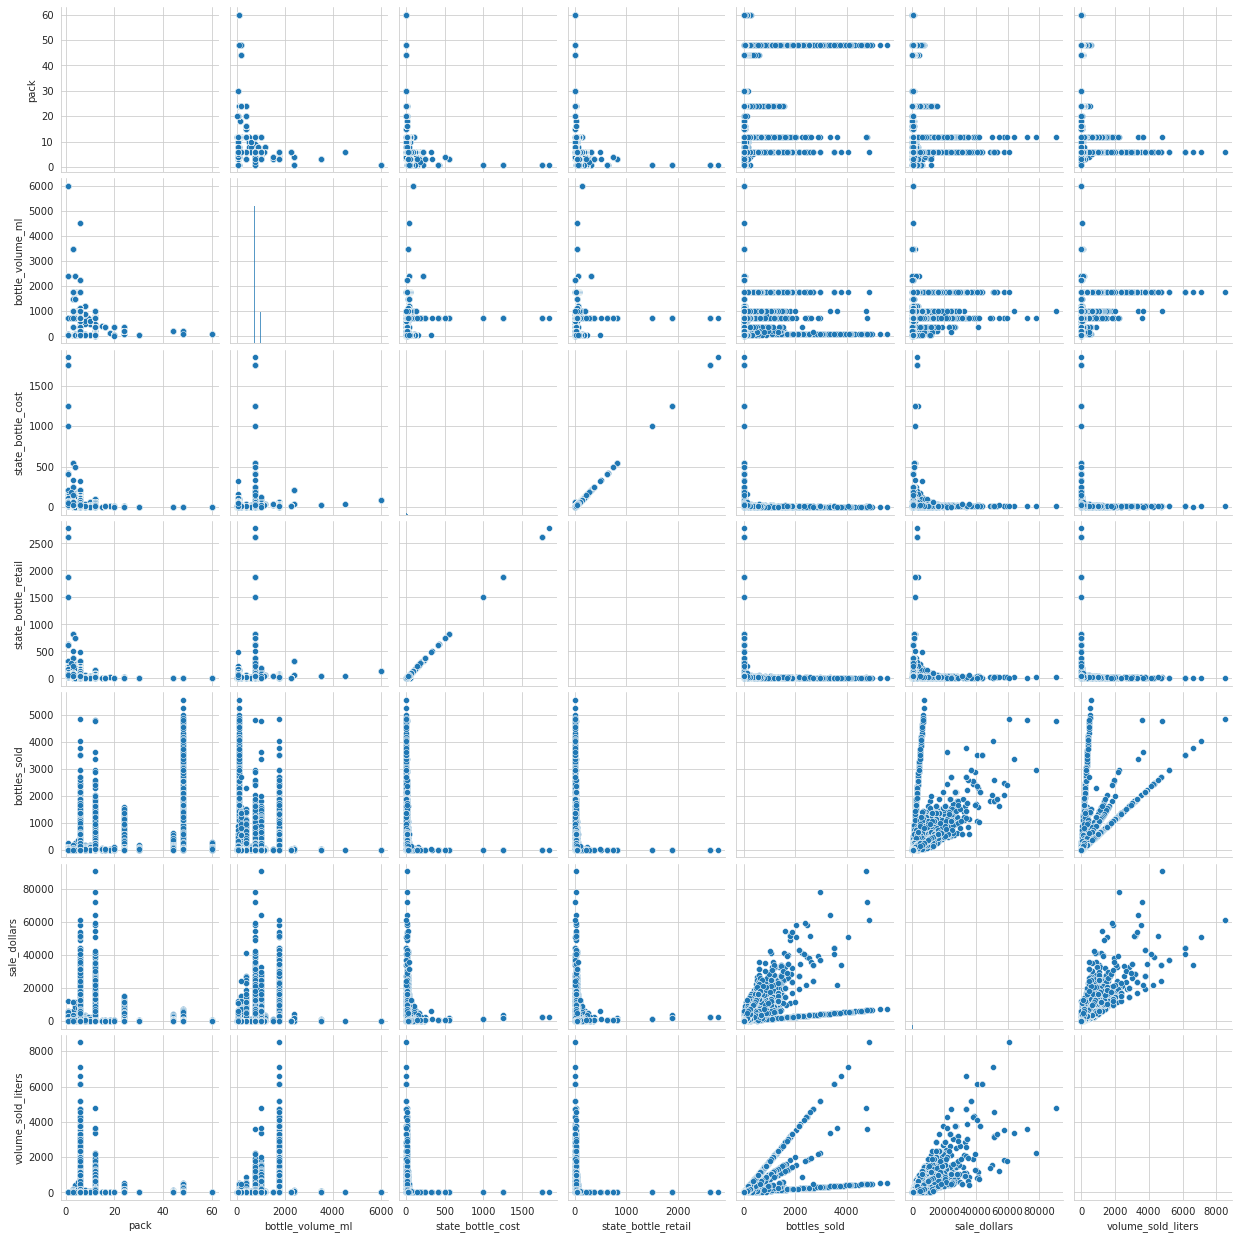

In [52]:
# Create a pairplot to gain some initial understanding about any potential correlation between bottles_sold and other numerical features
num_feature = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'sale_dollars', 'volume_sold_liters']
sns.pairplot(data_2020[num_feature])

Below are key observations from the pairplot. 
1. Bottles_sold and **pack** do not have a linear correlation. More common pack size such as 6, 12, 24 and 48 has a much higher demand than other "odd" pack size of 3, 5, 15 and so on. This relationship suggested that I should perform feature engineering to transform pack into a categorical feature. Specifically, I would combine existing pack values into 6, 12, 24, 48 and others, then apply one-hot encoding to these 5 new categorical values. 
2. Similar to pack, **bottle_volume_ml** do not have a linear correlation. More common bottle size below 2 liters has greater demand than those larger than 2 liters. Therefore, I would also perform feature engineering to treat the bottle_volume_ml into a categorical feature. Specific rules will be examined below since the figure is too small to decipher. 
3. **state_bottle_cost** and **state_bottle_retail** showed very similar correlation to bottles_sold. The higher the cost or state retail price per bottle, the fewer bottles sold to retailers. Therefore, I would keep one as a feature and discard the other one. Between cost and retail price, I would opt to retain the state_bottle_retail since it would better reflect the quantity that retailers stock up.
4. **sales_dollars** and **volume_sold_liters** also requires feature engineering to calculate historical values to avoid look-ahead bias. Specifically, I will experiment with a variety of historical calculations such as N-day cummulative figure, last week figure, last month figure to decide on which historical value has the best predictive power for future demand. 

The next steps shown below will focus on: 
- Feature engineering for numerical variables
- Conduct hypothesis testing to comfirm predictive power of numerical features

<AxesSubplot:>

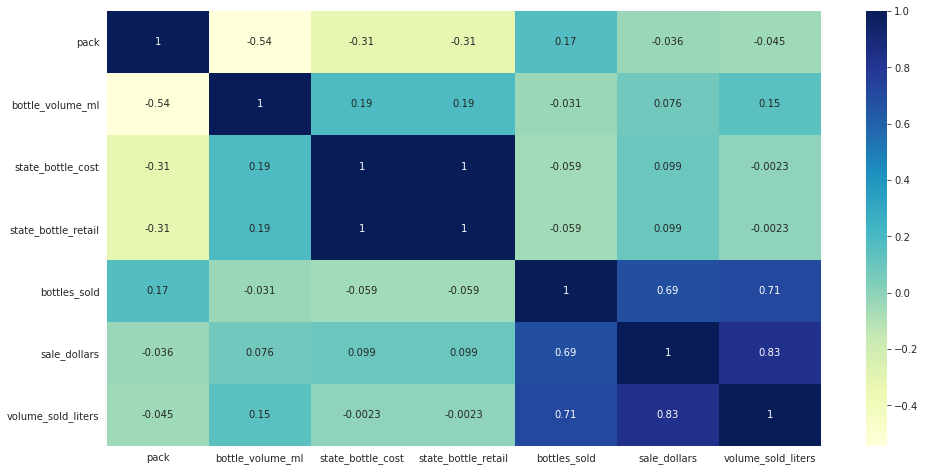

In [53]:
# Create the correlation heatmap
plt.figure(figsize = (16,8))
sns.heatmap(liquor_df[num_feature].corr(), annot = True, cmap = 'YlGnBu')

### pack

#### Feature Engineering: Pack size of 6, 12, 24, 48 and Others

In [54]:
# Create new categorical feature called pack_size
liquor_df['pack_size'] = np.where(liquor_df['pack'].isin([6, 12, 24, 48]), liquor_df['pack'], 'Others')

#### Assess predictive power

,sum_sq,df,F,PR(>F)
pack_size,1313808194705.04,4.00,5575.57,0.00
Residual,248125192490.97,4212.00,NaN,NaN


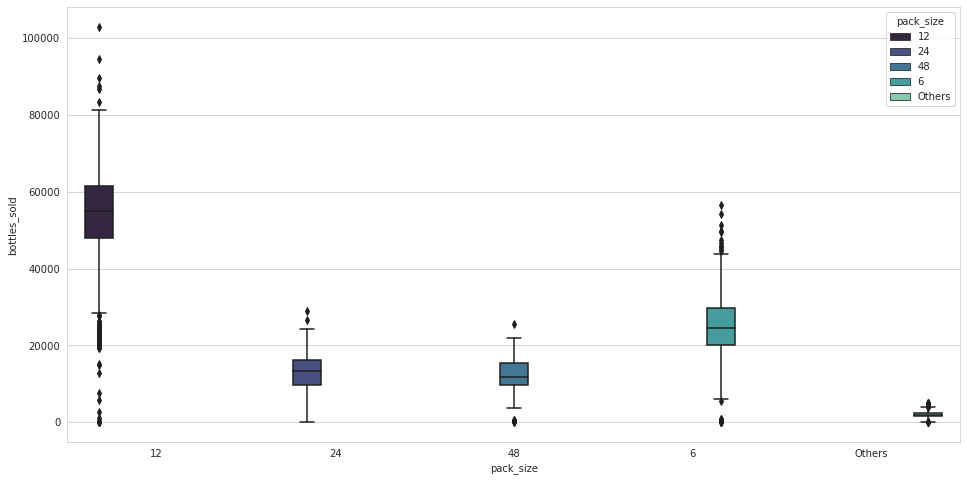

In [69]:
# Assess predictive power of pack_size to bottles_sold with boxplot and ANOVA
corr_boxplot_anova(liquor_df, 'pack_size', 'bottles_sold', 'date')

Since p-value is smaller than 0.05, I would reject the null hypothesis and conclude that pack_size has predictive power to bottles_sold, thus retaining it as a relevant feature. 

### bottle_volume_ml

In [70]:
pd.pivot_table(liquor_df, index = 'bottle_volume_ml', values = 'bottles_sold', aggfunc = np.sum)

,bottles_sold
bottle_volume_ml,
20,7605
25,3815
50,1946271
100,6946122
150,1175
175,12482
200,6198288
250,731
300,97996


#### Plot the correlation between bottle_volume_ml and bottles_sold

In [71]:
# Define a function to plot a scatterplot between one numerical variable against a numerical label across years
def multivariate_scatterplot(df, num_var, num_label, year_col):
    # Summarise the data into a long-form pivot table
    pv_table = pd.pivot_table(df, index = [year_col, num_var], values = num_label, aggfunc = np.sum).reset_index()
    # Plot each year's time series in its own facet 
    plt.figure(figsize = (16, 8))
    sns.set_style("whitegrid")
    g = sns.scatterplot(data = pv_table, x = num_var, y = num_label, hue = year_col, palette = "dark")
    return None

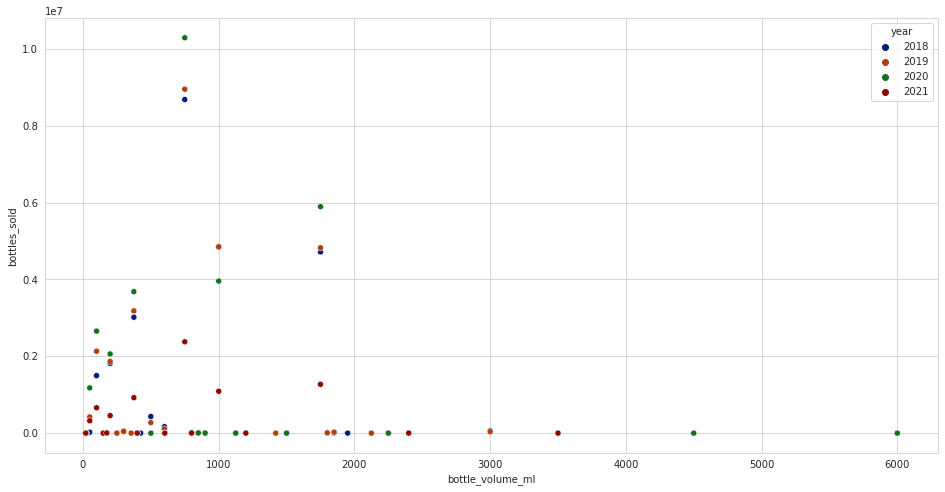

In [72]:
multivariate_scatterplot(liquor_df, 'bottle_volume_ml', 'bottles_sold', 'year')

Based on the above scatterplot and [typical spirits bottle sizes in US](https://www.diffordsguide.com/en-au/encyclopedia/235/bws/bottle-sizes-the-worlds-mandatory-bottle-sizes), it is observed that the bottles sold for standard bottle sizes are significantly higher than non-standardised size.

Among all standard sizes, bottles_sold also greatly varied with 750ml and 1750ml bottles seemed to be the most popular. Hence, similar to pack, I will treat bottle_volume_ml as a categorical feature instead of numerical feature. Specifically, I will group the different bottle_volume_ml into the following categories: 
- Standard size of 50, 100, 200, 375, 500, 750, 1000, 1750ml: retain the value of bottle_volume_ml
- Non-standard size: input as "Non-standard"

#### Feature Engineering: bottle_size of standard and non-standard

In [73]:
# Create new categorical feature called pack_size
liquor_df['bottle_size'] = np.where(liquor_df['bottle_volume_ml'].isin([50, 100, 200, 375, 750, 1000, 1750])
                                    , liquor_df['bottle_volume_ml'], 'Non-standard')

#### Assess predictive power

,sum_sq,df,F,PR(>F)
bottle_size,736498590907.29,7.00,3393.80,0.00
Residual,206503428925.45,6661.00,NaN,NaN


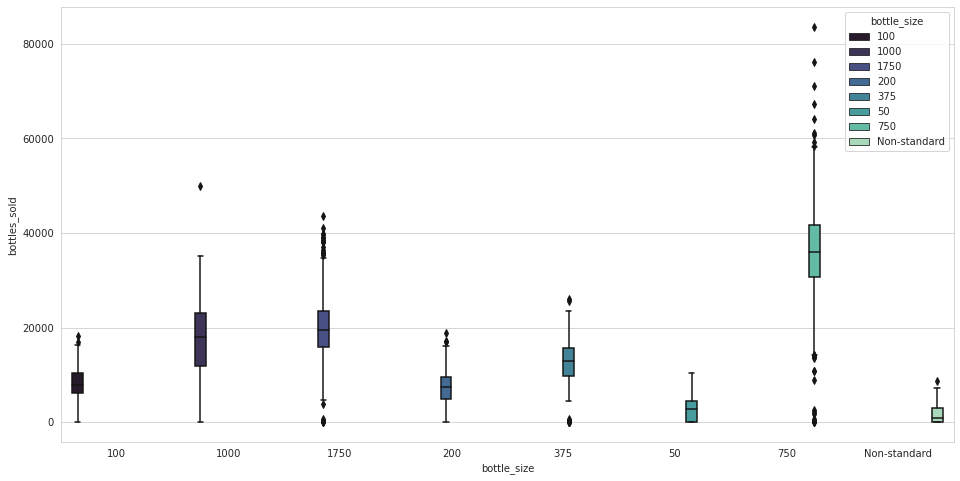

In [75]:
# Assess predictive power of pack_size to bottles_sold with boxplot and ANOVA
corr_boxplot_anova(liquor_df, 'bottle_size', 'bottles_sold', 'date')

Since p-value is smaller than 0.05, I would reject the null hypothesis and conclude that bottle_size has predictive power to bottles_sold, thus retaining it as a relevant feature. 

### bottles_sold

#### Does bottles_sold show a stationary of non-stationary time series?

Below are key points explaining why stationary time series matters in demand forecasting based on the book [Forecasting: Principles and Practice](https://otexts.com/fpp2/stationarity.html), [this article](https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454#:~:text=Stationarity%20is%20an%20important%20concept,is%20independent%20of%20one%20another.) and [statsmodel documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

**Stationary vs non-stationary time series**

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

**Implications on demand forecasting**

Many statistical models require the series to be stationary to make effective and precise predictions. In general, a non-stationary time series cannot be forecasted using traditional time series models such as AutoRegressive Moving Average (ARMA). If the bottles_sold is non-stationary, I will have 2 options: 
- Option 1: Apply first differencing or logarithmic transform to make the time series stationary (i.e. remove the trend and seasonality)
- Option 2: Choose other time series models that accommodate non-stationary time series such as AutoRegressive Integrated Moving Average (ARIMA). 

**2 approaches to test for stationarity**
- Visual test to observe whether there is any trend or seasonality
- Statistical hypothesis tests: also known as the unit root test

**Common statistical hypothesis tests for stationarity**
Common tests include Augmented Dickey-Fuller (ADF) Test, Phillips-Perron Unit Root Tests and Kwiatkowski, Philips, Schmidt and Shin (KPSS) test. Among them, KPSS is the most popular and  (a.k.a. the unit root test) - useful when it is difficult to tell based on visual test

Since I want to assess the true stationarity of the time series, I will be using the visual test, the KPSS test and the ADF test with the level of significance of 0.05. Code snippet is adapted from [statsmodel documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

<AxesSubplot:xlabel='date', ylabel='bottles_sold'>

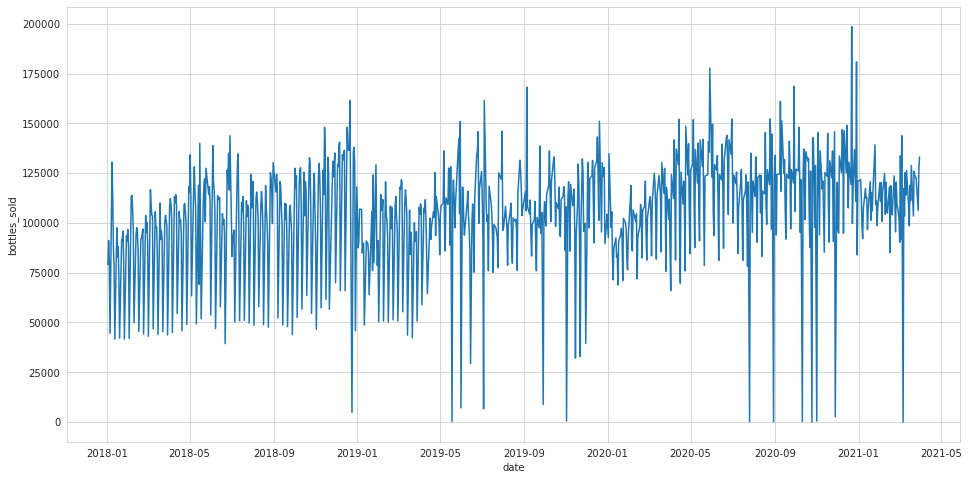

In [98]:
# Plot the overall bottles_sold for the entire time series
daily_bottles_sold = pd.pivot_table(liquor_df, index = 'date', values = ['bottles_sold', 'sale_dollars', 'volume_sold_liters'], aggfunc = np.sum).reset_index()
plt.figure(figsize = (16,8))
sns.lineplot(data = daily_bottles_sold, x = 'date', y = 'bottles_sold', palette = 'mako')

In [82]:
# Conduct KPSS test to check for stationarity of the time series
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(daily_bottles_sold['bottles_sold'])

Results of KPSS Test:
Test Statistic          3.50
p-value                 0.01
Lags Used               7.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
Critical Value (2.5%)   0.57
Critical Value (1%)     0.74
dtype: float64


Since p-value of the KPSS test is smaller than the significiance level of 0.05, I will reject the null hypothesis and conclude that bottles_sold exhibits a non-stationary time series. 

In [84]:
# Conduct ADF test to check for stationarity of the time series
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(daily_bottles_sold['bottles_sold'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.13
p-value                         0.00
#Lags Used                     19.00
Number of Observations Used   827.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


Considering the significance level of 0.05 and the p-value of 0.00, ADF test indicates that the null hypothesis is rejected, which means the series is stationary. 

Since the KPSS indicates non-stationary while ADF indicates stationary, the series is difference stationary. In other words, as raw values, the series is non-stationary, but I can use differencing transform to make the series stationary. 

#### How does differencing transform help to correct non-stationarity (if we want to use ARMA for demand forecasting)? 

<AxesSubplot:xlabel='date', ylabel='bottles_sold_diff'>

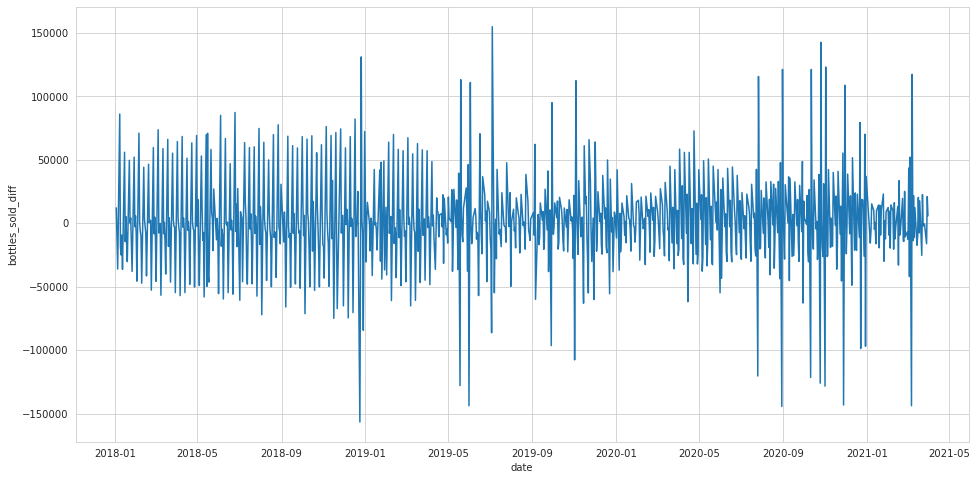

In [86]:
# Apply differencing transform
daily_bottles_sold['bottles_sold_diff'] = daily_bottles_sold['bottles_sold'] - daily_bottles_sold['bottles_sold'].shift(1)
plt.figure(figsize = (16,8))
sns.lineplot(data = daily_bottles_sold, x = 'date', y = 'bottles_sold_diff', palette = 'mako')

In [88]:
# Check for stationarity with KPSS
kpss_test(daily_bottles_sold['bottles_sold_diff'].dropna())

Results of KPSS Test:
Test Statistic           0.03
p-value                  0.10
Lags Used               38.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
Critical Value (1%)      0.74
dtype: float64


In [89]:
# Check for stationarity with ADF
adf_test(daily_bottles_sold['bottles_sold_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -10.16
p-value                         0.00
#Lags Used                     18.00
Number of Observations Used   827.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


Based on the KPSS and ADF test results, applying differencing transform to create a new feature called bottles_sold_diff having strict stationary time series. This new feature is now suitable for predicting demand with ARMA forecasting model. 

#### Does the current bottles_sold value correlate with the previous values from the same time series? If yes, what time lag shows the most significant correlation? 

I am testing whether the bottles_sold from previous days can be used to foretell what demand for liquor will be today and the days after. If yes, then I would like to know the most optimal lag variable. 

Two related concepts here is Partial Auto-Correlation Function (PACF) and Auto-Correlation Function (ACF). I will be using pacf and acf functions from statsmodel to conduct the test. 

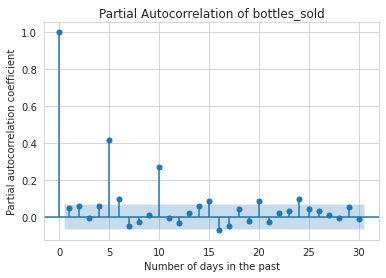

In [91]:
# Plot the partical auto-correlation for bottles_sold
plot_pacf(daily_bottles_sold['bottles_sold'], title = 'Partial Autocorrelation of bottles_sold')
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

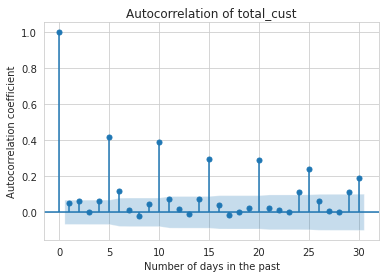

In [92]:
# Plot the autocorrelation for bottles_sold
plot_acf(daily_bottles_sold['bottles_sold'], title='Autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation coefficient')
plt.show()

Since **all potential lags showed weak correlation (approximately 0.4) with bottles_sold at t+0, I would not use any lag variable related to bottles_sold to predict demand.** 

### sale_dollars

#### Does the current bottles_sold value correlate with the previous sale_dollars values from the same time series? If yes, what time lag shows the most significant correlation? 

As mentioned earlier, to avoid look-ahead bias, I can only use the historical values of sale_dollars to predict demand. Therefore, I will check for potential correlation between sales_dollar and bottles_sold with different rolling means and rolling standard deviations. The code is adapted from this [GitHub](https://github.com/julianikulski/bike-sharing/blob/master/bike_sharing_demand.ipynb).

In [95]:
# Define a function to get list for all correlations between a numerical feature and a numerical label with different rolling means

def best_window_mean(x, y, max_window):
    corr_var_label = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_label_ti = list(y[i:])
        corr, p_val = pearsonr(total_label_ti, roll_val)
        corr_var_label.append(corr)
    # get the optimal window size for rolling mean between a feature and total_cust
    max_val = np.argmax(corr_var_label)
    min_val = np.argmin(corr_var_label)
    opt_corr_min = corr_var_label[min_val]
    opt_corr_max = corr_var_label[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [106]:
# Define a function to get list for all correlations between a numerical feature and a numerical label with different rolling standard deviations

def best_window_std(x, y, max_window):
    corr_var_label = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_label_ti = list(y[i:])
        corr, p_val = pearsonr(total_label_ti, roll_val)
        corr_var_label.append(corr)
    # get the optimal window size for rolling std between a feature and total_cust
    max_val = np.argmax(corr_var_label)
    min_val = np.argmin(corr_var_label)
    opt_corr_min = corr_var_label[min_val]
    opt_corr_max = corr_var_label[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [130]:
# Get the optimal number for rolling mean of sale_dollars
print(best_window_mean(daily_bottles_sold['sale_dollars'], daily_bottles_sold['bottles_sold'], 30))

{10: 0.2679726920167121, 1: 0.02785042187190967}


In [131]:
# Get the optimal window for rolling standard deviations of sale_dollars
print(best_window_std(daily_bottles_sold['sale_dollars'], daily_bottles_sold['bottles_sold'], 30))

{2: 0.2741424891176405, 14: 0.03466449268330607}


Even **the window showing the maximum correlation coefficient showed very little correlation with bottles_sold. Therefore, I will discard the feature sale_dollars.**

### volume_sold_liters

Similar to sale_dollars, to avoid look-ahead bias, I can only use the historical values of volume_sold_liters to predict demand. Therefore, I will check for potential correlation between volume_sold_liters and bottles_sold with different rolling means and rolling standard deviations. The code is adapted from this [GitHub](https://github.com/julianikulski/bike-sharing/blob/master/bike_sharing_demand.ipynb).

In [116]:
# Get the optimal number for rolling mean of volume_sold_liters
print(best_window_mean(daily_bottles_sold['volume_sold_liters'], daily_bottles_sold['bottles_sold'], 60))

{10: 0.2233766497537484, 1: -0.013642729029194334}


In [115]:
# Get the optimal window for rolling standard deviations of volume_sold_liters
print(best_window_std(daily_bottles_sold['volume_sold_liters'], daily_bottles_sold['bottles_sold'], 60))

{2: 0.2776172187556798, 58: -0.02094118951335172}


**The resulting correlation showed lagged volume_sold_liters has very little predictive power over bottles_sold. Therefore, I will discard the feature volume_sold_liters.**

**KEY TAKEAWAYS**
1. Feature Selection
    1. Retain: liquor_type (category_name), origin (category_name), county, item_description, day_of_week, pack_size, bottle_size, month (date), day_of_week (date), city
    2. KIV for further feature engineering:
        - city: enrich with population to see what could explain the vast difference in demand across cities. 
    3. Discard: year, date, pack, bottle_volume_ml, sales_dollar, volume_sold_liters
2. Stationarity: Bottles_sold time series is non-stationary. Hence ARMA is not suitable for demand forecasting. 

**NEXT STEPS:**  Build Machine Learning pipelines

**Multicollinearity and regression model**

When it comes to the interpretability of the Machine Learning Models, nothing comes close to the simplicity and interpretability of the Linear Regression. But there can be certain issues with the interpretability of the Linear Regression, especially when the assumptions of Linear regression known as Multicollinearity violated.

Multicollinearity happens when independent variables in the regression model are highly correlated to each other. It makes it hard for interpretation of model and also creates overfitting problem. It is a common assumption that people test before selecting the variables into regression model.